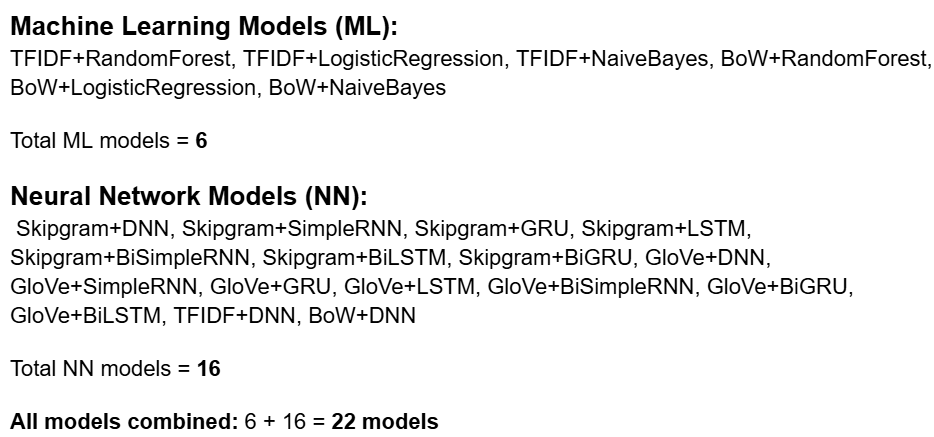

GPU

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
import gc
gc.collect()


0

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5803879436056729017
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7324712828127305089
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


Setup & Install Required Libraries

In [ ]:
# Install necessary libraries
!pip install nltk
!pip install wordcloud
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

# Imports
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


Load Dataset

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load your datasets
train_path = "/content/Question Answer Classification Dataset 4[Training] (1).csv"
test_path  = "/content/[Updated] Question Answer Classification Dataset[Test].csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

# Clean column names (remove extra spaces if any)
df_train.columns = df_train.columns.str.strip()
df_test.columns  = df_test.columns.str.strip()

# Heavy preprocessing (example: lowercase + remove punctuation)
df_train['clean_text'] = df_train.iloc[:, 0].str.lower().str.replace(r'[^a-z ]', '', regex=True)
df_test['clean_text']  = df_test.iloc[:, 0].str.lower().str.replace(r'[^a-z ]', '', regex=True)

# Save preprocessed versions to Google Drive (checkpoint)
df_train.to_csv("/content/drive/MyDrive/preprocessed_train.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/preprocessed_test.csv", index=False)


Mounted at /content/drive


In [ ]:
###################################################3
df_train = pd.read_csv("/content/preprocessed_train (1).csv")
df_test  = pd.read_csv("/content/preprocessed_test (1).csv")


#EDA

In [ ]:
# Shape of training and testing data
print("Training Data Shape:", df_train.shape)
print("Testing Data Shape:", df_test.shape)


Training Data Shape: (279999, 3)
Testing Data Shape: (59999, 3)


In [ ]:
# Count how many classes
df_train['Class'].value_counts()


Bar plot of class distribution

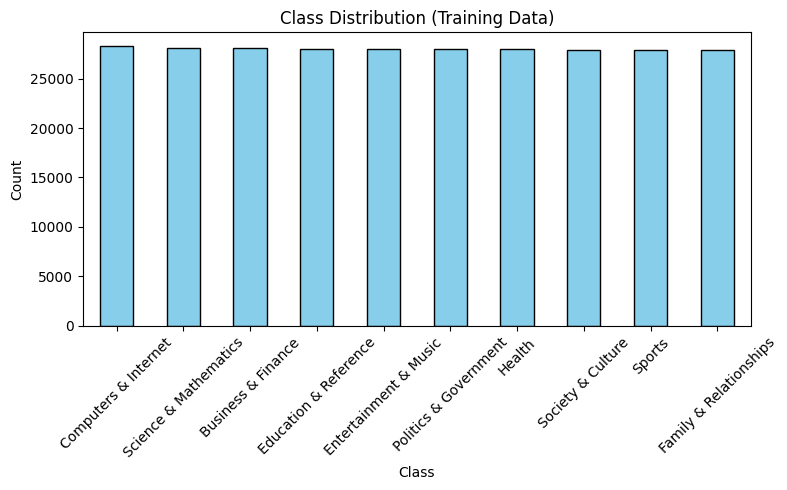

In [ ]:

class_counts = df_train['Class'].value_counts()

plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Class Distribution (Training Data)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Wordcloud for quick look at frequent words

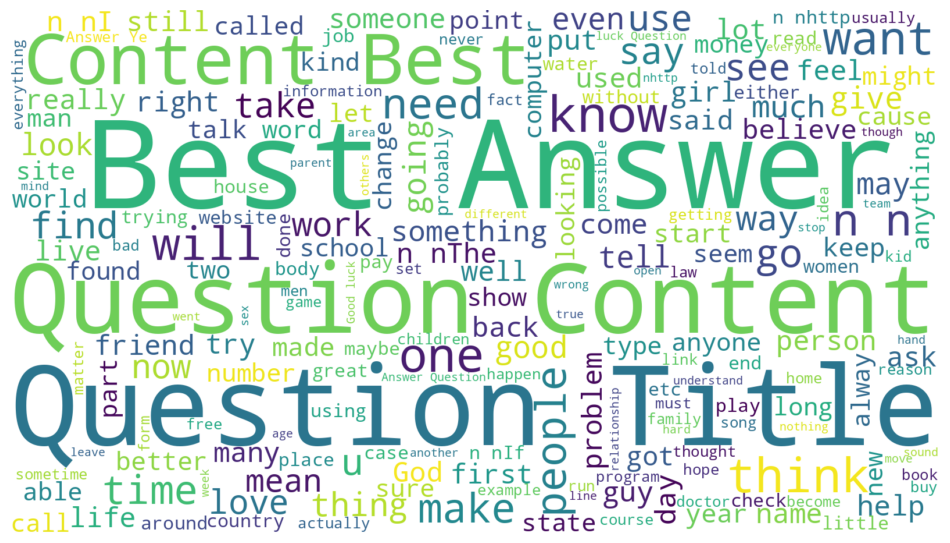

In [ ]:

text = " ".join(df_train["QA Text"].astype(str))

wordcloud = WordCloud(width=1600, height=900, background_color='white').generate(text)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#Preprocessing

In [ ]:
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords


stop_words = set(stopwords.words('english'))


stop_words.update([
    "question", "answer", "title", "content", "what", "whats", "where", "who", "which",
    "when", "how", "why", "did", "does", "do", "is", "are", "was", "were", "i", "ive",
    "you", "your", "my", "me", "he", "she", "they", "them", "it", "we", "us", "a", "an",
    "the", "to", "of", "for", "and", "or", "in", "on", "with", "by", "at", "from",
    "about", "any", "someone", "some", "good", "like", "would", "can", "could",
    "should", "will", "just", "really", "title:", "content:", "title", "content"
])


 Training Data

In [ ]:

# Converting to lowercase
df_train['QA Text'] = df_train['QA Text'].apply(lambda x: x.lower())

# Splitting into individual words
df_train['QA Text'] = df_train['QA Text'].apply(lambda x: x.split())

# Remove stopwords
df_train['QA Text'] = df_train['QA Text'].apply(lambda words: [word for word in words if word not in stop_words])

# Join words back into single string
df_train['QA Text'] = df_train['QA Text'].apply(lambda words: " ".join(words))



Testing Data

In [ ]:
# Converting to lowercase
df_test['QA Text'] = df_test['QA Text'].apply(lambda x: x.lower())

# Splitting into individual words
df_test['QA Text'] = df_test['QA Text'].apply(lambda x: x.split())

# Remove stopwords
df_test['QA Text'] = df_test['QA Text'].apply(lambda words: [word for word in words if word not in stop_words])

# Join words back into single string
df_test['QA Text'] = df_test['QA Text'].apply(lambda words: " ".join(words))



In [ ]:
# Check sample after preprocessing
df_train.head(10)

QA Text                  Class  \
0  pcos & know low gi diet?? positive & real answ...                 Health   
1  find skateboard trucks? wieght core trucks im ...                 Sports   
2  find info survive natural disaster hurricane e...  Science & Mathematics   
3  illegal immigration crime, agree/disagree? bes...  Politics & Government   
4  "spare rod spoil child": kind parenting advice...      Society & Culture   
5  better player negro leagues baseball james "co...                 Sports   
6  first baseball player suspended drug use? best...                 Sports   
7  saint patrick drive snakes ireland? want belie...      Society & Culture   
8  clean 11months... took one hit pot...next day,...                 Health   
9  company located 3118 w.thomas rd #702 phoenix,...     Business & Finance   

                                          clean_text  
0  question titlei have pcos  would like to know ...  
1  question titlewere to find some good skateboar...  
2  question titlewhere can i find info about how ...  
3  question titleillegal immigration is a crime a...  
4  question titlespare the rod and spoil the chil...  
5  question titlewho was a better player in the n...  
6  question titlefirst baseball player suspended ...  
7  question titledid saint patrick really drive t...  
8  question titleive been clean for months i then...  
9  question titlewhat company is located at  wtho...

In [ ]:
# Save preprocessed train and test datasets (including 'QA Text')
df_train.to_csv("/content/preprocessed_train (1).csv", index=False)
df_test.to_csv("/content/preprocessed_test (1).csv", index=False)

print("Preprocessed train and test datasets (with 'QA Text') saved to Drive!")


Preprocessed train and test datasets (with 'QA Text') saved to Drive!


In [ ]:
#######################################33
import pandas as pd

# Load preprocessed train and test datasets
df_train = pd.read_csv("/content/preprocessed_train (1).csv")
df_test = pd.read_csv("/content/preprocessed_test (1).csv")




#Implementation of Word Representation Techniques: BoW, TF-IDF, GloVe, and Skip-gram

Bag-of-Words (BoW)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=2000)
X_train_bow = bow_vectorizer.fit_transform(df_train['QA Text'])
X_test_bow  = bow_vectorizer.transform(df_test['QA Text'])

print("BoW Train shape:", X_train_bow.shape)
print("BoW Test shape:", X_test_bow.shape)


BoW Train shape: (279999, 2000)
BoW Test shape: (59999, 2000)


TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['QA Text'])
X_test_tfidf  = tfidf_vectorizer.transform(df_test['QA Text'])

print("TF-IDF features prepared.")
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)


TF-IDF features prepared.
X_train_tfidf shape: (279999, 1000)
X_test_tfidf shape: (59999, 1000)


GloVe Embeddings

In [ ]:
# Install gensim
!pip install gensim

# Import gensim downloader
import gensim.downloader as api

# Load GloVe 100d vectors
glove_model = api.load("glove-wiki-gigaword-100")



import os
import urllib.request
import zipfile

# Download GloVe embeddings (100d for memory efficiency)
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"
glove_dir = "glove.6B"

if not os.path.exists(glove_zip):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(glove_url, glove_zip)

if not os.path.exists(glove_dir):
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)

# Load 100-dimensional embeddings
embedding_index = {}
with open(os.path.join(glove_dir, "glove.6B.100d.txt"), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")


[==================================================] 100.0% 128.1/128.1MB downloaded
Loaded 400000 word vectors from GloVe.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Parameters
MAX_NUM_WORDS = 20000   # vocab size
MAX_SEQUENCE_LENGTH = 100  # sequence length

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['QA Text'])

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(df_train['QA Text'])
X_test_seq  = tokenizer.texts_to_sequences(df_test['QA Text'])

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(df_train['Class'])
y_test_int  = le.transform(df_test['Class'])

y_train_onehot = to_categorical(y_train_int)
y_test_onehot  = to_categorical(y_test_int)

print("Tokenization and padding done.")
print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape:", X_test_pad.shape)


Tokenization and padding done.
X_train_pad shape: (279999, 100)
X_test_pad shape: (59999, 100)


In [ ]:
EMBEDDING_DIM = 100  # 100d for memory efficiency
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# Initialize embedding matrix
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Embedding matrix ready:", embedding_matrix.shape)


Embedding matrix ready: (20000, 100)


In [ ]:
#saveeeeeeeeeee
import pandas as pd

# Save embedding matrix to CSV
pd.DataFrame(embedding_matrix).to_csv("embedding_matrix_glove100.csv", index=False)
print("Embedding matrix saved as embedding_matrix_glove100.csv")


Embedding matrix saved as embedding_matrix_glove100.csv


In [ ]:
#reload##############################
import pandas as pd
import numpy as np

# Load embedding matrix back from CSV
embedding_matrix = pd.read_csv("embedding_matrix_glove100.csv").values
print("Embedding matrix loaded:", embedding_matrix.shape)


Embedding matrix loaded: (20000, 100)


Skip-gram

In [ ]:
!pip install gensim

In [ ]:

import numpy as np
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import gc


train_tokens = [str(text).split() for text in df_train['QA Text']]
test_tokens  = [str(text).split() for text in df_test['QA Text']]

embedding_dim = 100  # moderate dimension to save memory


class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
    def on_epoch_begin(self, model):
        print(f"Epoch {self.epoch + 1} start")
    def on_epoch_end(self, model):
        print(f"Epoch {self.epoch + 1} end")
        self.epoch += 1


skipgram_model = Word2Vec(
    sentences=train_tokens,
    vector_size=embedding_dim,
    window=5,
    min_count=1,
    workers=4,
    sg=1,      # Skip-gram
    epochs=10,
    callbacks=[EpochLogger()]  # show epoch updates
)


def compute_avg_skipgram_fast(tokens_list, w2v_model):
    embedding_dim = w2v_model.vector_size
    n_samples = len(tokens_list)

    # Preallocate with float16 to save RAM
    X_avg = np.zeros((n_samples, embedding_dim), dtype=np.float16)


    wv = w2v_model.wv
    for i, tokens in enumerate(tokens_list):
        vecs = [wv[word] for word in tokens if word in wv.key_to_index]
        if vecs:
            X_avg[i] = np.mean(vecs, axis=0)
    return X_avg


X_train_skipgram_avg = compute_avg_skipgram_fast(train_tokens, skipgram_model)
X_test_skipgram_avg  = compute_avg_skipgram_fast(test_tokens, skipgram_model)

del skipgram_model
gc.collect()

print("Skip-gram average embeddings computed.")
print("X_train_skipgram_avg shape:", X_train_skipgram_avg.shape)
print("X_test_skipgram_avg shape:", X_test_skipgram_avg.shape)


Epoch 1 start
Epoch 1 end
Epoch 2 start
Epoch 2 end
Epoch 3 start
Epoch 3 end
Epoch 4 start
Epoch 4 end
Epoch 5 start
Epoch 5 end
Epoch 6 start
Epoch 6 end
Epoch 7 start
Epoch 7 end
Epoch 8 start
Epoch 8 end
Epoch 9 start
Epoch 9 end
Epoch 10 start
Epoch 10 end
Skip-gram average embeddings computed.
X_train_skipgram_avg shape: (279999, 100)
X_test_skipgram_avg shape: (59999, 100)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train_int = le.fit_transform(df_train['Class'])
y_test_int  = le.transform(df_test['Class'])

y_train_onehot = to_categorical(y_train_int)
y_test_onehot  = to_categorical(y_test_int)


In [ ]:
#saveeeeeeeeee
import numpy as np
import pickle

# --- Save embeddings ---
np.save('X_train_skipgram_avg.npy', X_train_skipgram_avg)
np.save('X_test_skipgram_avg.npy', X_test_skipgram_avg)

# --- Save label arrays ---
np.save('y_train_onehot.npy', y_train_onehot)
np.save('y_test_onehot.npy', y_test_onehot)

# --- Optionally save the LabelEncoder ---
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("All embeddings and labels saved successfully.")


All embeddings and labels saved successfully.


In [ ]:
################3
import numpy as np
import pickle

# --- Load embeddings ---
X_train_skipgram_avg = np.load('X_train_skipgram_avg.npy')
X_test_skipgram_avg  = np.load('X_test_skipgram_avg.npy')

# --- Load labels ---
y_train_onehot = np.load('y_train_onehot.npy')
y_test_onehot  = np.load('y_test_onehot.npy')

# --- Load LabelEncoder ---
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

print("All embeddings and labels loaded successfully.")
print("X_train shape:", X_train_skipgram_avg.shape)
print("y_train shape:", y_train_onehot.shape)


MEMORY

In [ ]:
df_train.to_csv("/content/drive/MyDrive/preprocessed_train_backup.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/preprocessed_test_backup.csv", index=False)


Confiussion matrix

In [ ]:
##########################################
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Plots a confusion matrix as a heatmap.

    Parameters:
    - y_true: array-like of true labels
    - y_pred: array-like of predicted labels
    - labels: list of label names (optional)
    - title: title of the plot
    """
    cm = confusion_matrix(y_true, y_pred)

    if labels is None:
        labels = np.unique(y_true)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

    return cm


In [1]:
##########################3
import matplotlib.pyplot as plt

def plot_history(history, title):
    """
    Plots training vs validation accuracy and loss curves.

    Parameters:
    -----------
    history : keras.callbacks.History
        The history object returned by model.fit()
    title : str
        Custom headline/title (e.g., 'GloVe + LSTM')
    """
    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


#Experiments with Bow Representation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
print(df_train.columns)
print(df_test.columns)


Index(['QA Text', 'Class', 'clean_text'], dtype='object')
Index(['QA Text', 'Class', 'clean_text'], dtype='object')


In [ ]:
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


BoW + Random Forest

=== BoW + Random Forest (Faster CPU) ===
Accuracy: 0.5076584609743495
F1-score (Macro): 0.5103660443898066
F1-score (Weighted): 0.5103644891208586
Classification Report:
                         precision    recall  f1-score   support

    Business & Finance       0.55      0.31      0.40      6000
  Computers & Internet       0.61      0.75      0.67      6000
 Education & Reference       0.56      0.21      0.31      6000
 Entertainment & Music       0.76      0.32      0.45      6000
Family & Relationships       0.53      0.69      0.60      5999
                Health       0.65      0.52      0.58      6000
 Politics & Government       0.65      0.57      0.61      6000
 Science & Mathematics       0.25      0.74      0.37      6000
     Society & Culture       0.56      0.39      0.46      6000
                Sports       0.78      0.55      0.65      6000

              accuracy                           0.51     59999
             macro avg       0.59      0.51      0.51     5

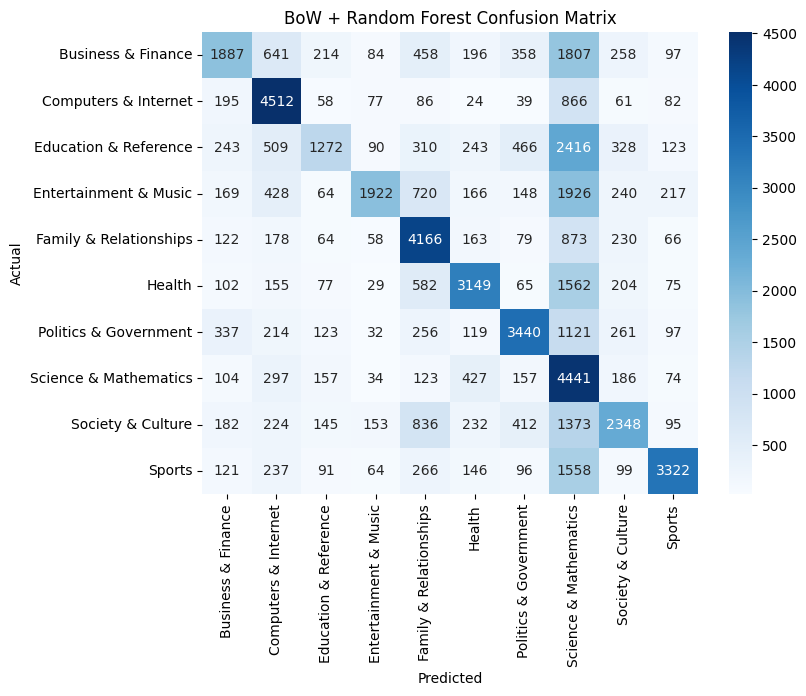

array([[1887,  641,  214,   84,  458,  196,  358, 1807,  258,   97],
       [ 195, 4512,   58,   77,   86,   24,   39,  866,   61,   82],
       [ 243,  509, 1272,   90,  310,  243,  466, 2416,  328,  123],
       [ 169,  428,   64, 1922,  720,  166,  148, 1926,  240,  217],
       [ 122,  178,   64,   58, 4166,  163,   79,  873,  230,   66],
       [ 102,  155,   77,   29,  582, 3149,   65, 1562,  204,   75],
       [ 337,  214,  123,   32,  256,  119, 3440, 1121,  261,   97],
       [ 104,  297,  157,   34,  123,  427,  157, 4441,  186,   74],
       [ 182,  224,  145,  153,  836,  232,  412, 1373, 2348,   95],
       [ 121,  237,   91,   64,  266,  146,   96, 1558,   99, 3322]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score

# Train Random Forest
rf_bow = RandomForestClassifier(
    n_estimators=100,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

rf_bow.fit(X_train_bow, df_train['Class'])

# Predict
y_pred_bow_rf = rf_bow.predict(X_test_bow)

# Evaluate
print("=== BoW + Random Forest (Faster CPU) ===")

# Accuracy
rf_accuracy = accuracy_score(df_test['Class'], y_pred_bow_rf)
print("Accuracy:", rf_accuracy)

# F1-score
f1_macro_rf = f1_score(df_test['Class'], y_pred_bow_rf, average='macro')
f1_weighted_rf = f1_score(df_test['Class'], y_pred_bow_rf, average='weighted')
print("F1-score (Macro):", f1_macro_rf)
print("F1-score (Weighted):", f1_weighted_rf)

# Classification report
rf_class_report = classification_report(df_test['Class'], y_pred_bow_rf, output_dict=True)
print("Classification Report:\n", classification_report(df_test['Class'], y_pred_bow_rf))

# Plot confusion matrix using the function
plot_confusion_matrix(df_test['Class'], y_pred_bow_rf, labels=np.unique(df_test['Class']),
                      title="BoW + Random Forest Confusion Matrix")


BoW + Logistic Regression

=== BoW + Logistic Regression ===
Accuracy: 0.6207270121168686
F1-score (Macro): 0.6162762796271981
F1-score (Weighted): 0.6162751816609586
Classification Report:
                         precision    recall  f1-score   support

    Business & Finance       0.53      0.42      0.47      6000
  Computers & Internet       0.76      0.79      0.77      6000
 Education & Reference       0.49      0.42      0.45      6000
 Entertainment & Music       0.52      0.62      0.57      6000
Family & Relationships       0.66      0.71      0.68      5999
                Health       0.69      0.70      0.70      6000
 Politics & Government       0.71      0.65      0.68      6000
 Science & Mathematics       0.58      0.69      0.63      6000
     Society & Culture       0.57      0.46      0.51      6000
                Sports       0.67      0.75      0.71      6000

              accuracy                           0.62     59999
             macro avg       0.62      0.62      0.62     59999
  

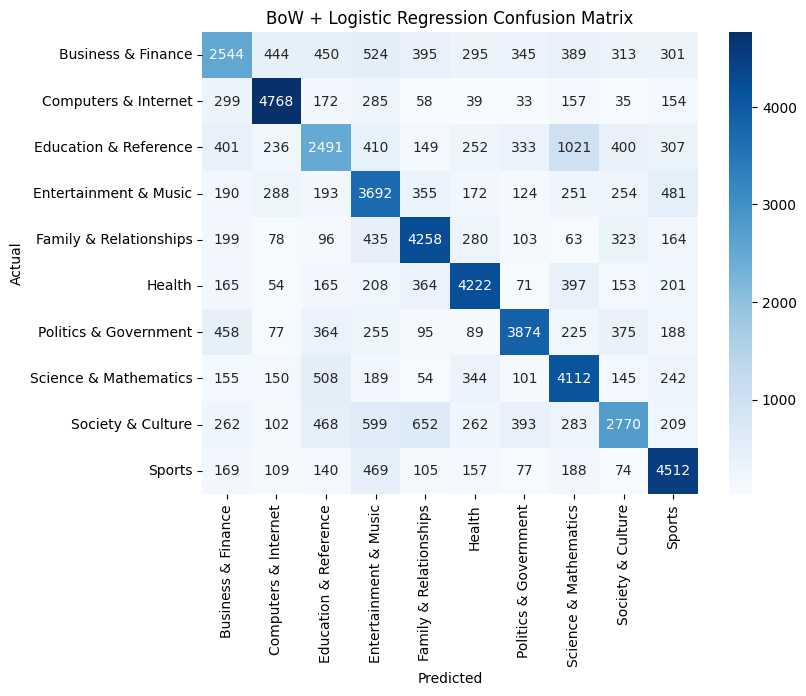

array([[2544,  444,  450,  524,  395,  295,  345,  389,  313,  301],
       [ 299, 4768,  172,  285,   58,   39,   33,  157,   35,  154],
       [ 401,  236, 2491,  410,  149,  252,  333, 1021,  400,  307],
       [ 190,  288,  193, 3692,  355,  172,  124,  251,  254,  481],
       [ 199,   78,   96,  435, 4258,  280,  103,   63,  323,  164],
       [ 165,   54,  165,  208,  364, 4222,   71,  397,  153,  201],
       [ 458,   77,  364,  255,   95,   89, 3874,  225,  375,  188],
       [ 155,  150,  508,  189,   54,  344,  101, 4112,  145,  242],
       [ 262,  102,  468,  599,  652,  262,  393,  283, 2770,  209],
       [ 169,  109,  140,  469,  105,  157,   77,  188,   74, 4512]])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, accuracy_score

# Train Logistic Regression
lr_bow = LogisticRegression(max_iter=2000, n_jobs=-1)
lr_bow.fit(X_train_bow, df_train['Class'])

# Predict
y_pred_bow_lr = lr_bow.predict(X_test_bow)

# Evaluate
print("=== BoW + Logistic Regression ===")

# Accuracy
lr_accuracy = accuracy_score(df_test['Class'], y_pred_bow_lr)
print("Accuracy:", lr_accuracy)

# F1-score
f1_macro_lr = f1_score(df_test['Class'], y_pred_bow_lr, average='macro')
f1_weighted_lr = f1_score(df_test['Class'], y_pred_bow_lr, average='weighted')
print("F1-score (Macro):", f1_macro_lr)
print("F1-score (Weighted):", f1_weighted_lr)

# Classification report
lr_class_report = classification_report(df_test['Class'], y_pred_bow_lr, output_dict=True)
print("Classification Report:\n", classification_report(df_test['Class'], y_pred_bow_lr))

# Plot confusion matrix using the reusable function
plot_confusion_matrix(df_test['Class'], y_pred_bow_lr, labels=np.unique(df_test['Class']),
                      title="BoW + Logistic Regression Confusion Matrix")


BoW + Naive Bayes

=== BoW + Naive Bayes ===
Accuracy: 0.616543609060151
F1-score (Macro): 0.6124931104917024
F1-score (Weighted): 0.6124923422372848
Classification Report:
                         precision    recall  f1-score   support

    Business & Finance       0.51      0.46      0.48      6000
  Computers & Internet       0.70      0.82      0.75      6000
 Education & Reference       0.50      0.40      0.45      6000
 Entertainment & Music       0.51      0.58      0.54      6000
Family & Relationships       0.58      0.76      0.66      5999
                Health       0.70      0.70      0.70      6000
 Politics & Government       0.72      0.64      0.68      6000
 Science & Mathematics       0.66      0.65      0.65      6000
     Society & Culture       0.57      0.47      0.52      6000
                Sports       0.71      0.69      0.70      6000

              accuracy                           0.62     59999
             macro avg       0.62      0.62      0.61     59999
          w

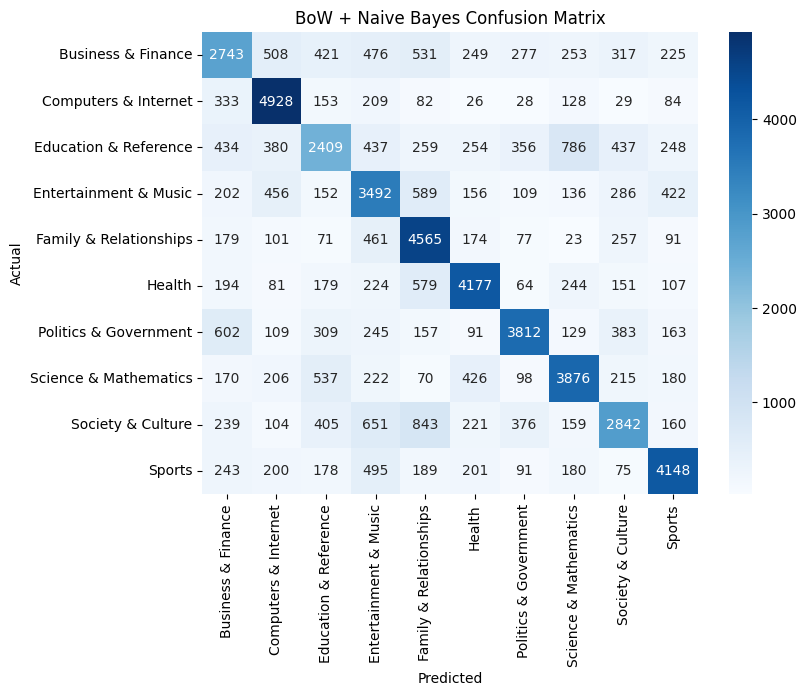

array([[2743,  508,  421,  476,  531,  249,  277,  253,  317,  225],
       [ 333, 4928,  153,  209,   82,   26,   28,  128,   29,   84],
       [ 434,  380, 2409,  437,  259,  254,  356,  786,  437,  248],
       [ 202,  456,  152, 3492,  589,  156,  109,  136,  286,  422],
       [ 179,  101,   71,  461, 4565,  174,   77,   23,  257,   91],
       [ 194,   81,  179,  224,  579, 4177,   64,  244,  151,  107],
       [ 602,  109,  309,  245,  157,   91, 3812,  129,  383,  163],
       [ 170,  206,  537,  222,   70,  426,   98, 3876,  215,  180],
       [ 239,  104,  405,  651,  843,  221,  376,  159, 2842,  160],
       [ 243,  200,  178,  495,  189,  201,   91,  180,   75, 4148]])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report, accuracy_score

# Train Naive Bayes
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, df_train['Class'])

# Predict
y_pred_bow_nb = nb_bow.predict(X_test_bow)

# Evaluate
print("=== BoW + Naive Bayes ===")

# Accuracy
nb_accuracy = accuracy_score(df_test['Class'], y_pred_bow_nb)
print("Accuracy:", nb_accuracy)

# F1-score
f1_macro_nb = f1_score(df_test['Class'], y_pred_bow_nb, average='macro')
f1_weighted_nb = f1_score(df_test['Class'], y_pred_bow_nb, average='weighted')
print("F1-score (Macro):", f1_macro_nb)
print("F1-score (Weighted):", f1_weighted_nb)

# Classification report
nb_class_report = classification_report(df_test['Class'], y_pred_bow_nb, output_dict=True)
print("Classification Report:\n", classification_report(df_test['Class'], y_pred_bow_nb))

# Plot confusion matrix using the reusable function
plot_confusion_matrix(df_test['Class'], y_pred_bow_nb, labels=np.unique(df_test['Class']),
                      title="BoW + Naive Bayes Confusion Matrix")


BoW + Deep Neural Network

BoW Train shape: (279999, 1000)
BoW Test shape: (59999, 1000)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        64,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,474 (259.66 KB)

 Trainable params: 66,474 (259.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.5138 - loss: 1.5090 - val_accuracy: 0.5937 - val_loss: 1.2584
Epoch 2/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.5942 - loss: 1.2599 - val_accuracy: 0.5979 - val_loss: 1.2405
Epoch 3/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6014 - loss: 1.2265 - val_accuracy: 0.5986 - val_loss: 1.2335
Epoch 4/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6076 - loss: 1.2069 - val_accuracy: 0.6000 - val_loss: 1.2296
Epoch 5/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6109 - loss: 1.1939 - val_accuracy: 0.6028 - val_loss: 1.2240
Epoch 6/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.6140 - loss: 1.1825 - val_accuracy: 0.6018 - val_loss: 1.2274
Epoch 7/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.6178 - loss: 1.1720 - val_accuracy: 0.6000 - val_loss: 1.2302
Epoch 8/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.6199 - loss: 1.1647 - 

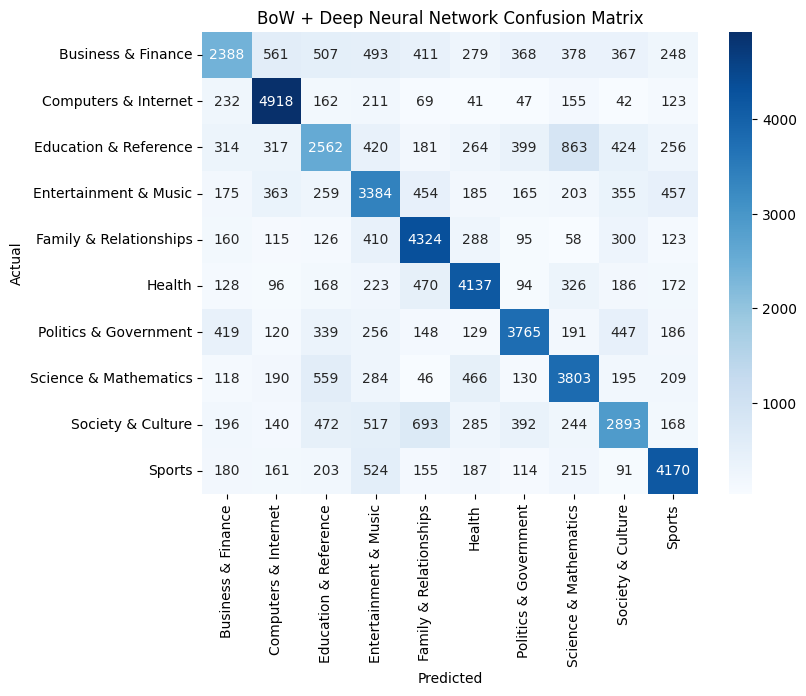

array([[2388,  561,  507,  493,  411,  279,  368,  378,  367,  248],
       [ 232, 4918,  162,  211,   69,   41,   47,  155,   42,  123],
       [ 314,  317, 2562,  420,  181,  264,  399,  863,  424,  256],
       [ 175,  363,  259, 3384,  454,  185,  165,  203,  355,  457],
       [ 160,  115,  126,  410, 4324,  288,   95,   58,  300,  123],
       [ 128,   96,  168,  223,  470, 4137,   94,  326,  186,  172],
       [ 419,  120,  339,  256,  148,  129, 3765,  191,  447,  186],
       [ 118,  190,  559,  284,   46,  466,  130, 3803,  195,  209],
       [ 196,  140,  472,  517,  693,  285,  392,  244, 2893,  168],
       [ 180,  161,  203,  524,  155,  187,  114,  215,   91, 4170]])

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import f1_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    if labels is None:
        labels = np.unique(y_true)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

    return cm

# -------------------------------
# BoW feature extraction (1000 features only)
bow_vectorizer = CountVectorizer(max_features=1000, stop_words="english")
X_train_bow = bow_vectorizer.fit_transform(df_train['QA Text'])
X_test_bow  = bow_vectorizer.transform(df_test['QA Text'])

print("BoW Train shape:", X_train_bow.shape)
print("BoW Test shape:", X_test_bow.shape)

# Convert sparse matrix to dense array (safe since only 1000 features)
X_train_bow_dense = X_train_bow.toarray()
X_test_bow_dense  = X_test_bow.toarray()

# -------------------------------
# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(df_train['Class'])
y_test_int  = le.transform(df_test['Class'])

y_train_onehot = to_categorical(y_train_int)
y_test_onehot  = to_categorical(y_test_int)

# -------------------------------
# Build smaller DNN (lighter layers)
with tf.device('/GPU:0'):   # remove if no GPU
    model_bow_dnn = Sequential([
        Dense(64, activation="relu", input_shape=(X_train_bow_dense.shape[1],)),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_bow_dnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model_bow_dnn.summary()

    # Train model (fewer epochs first)
    history_bow_dnn = model_bow_dnn.fit(
        X_train_bow_dense, y_train_onehot,
        epochs=8, batch_size=32, validation_split=0.2, verbose=1
    )

    # Predict
    y_pred_bow_dnn = model_bow_dnn.predict(X_test_bow_dense, verbose=0).argmax(axis=1)

# -------------------------------
# Evaluate
print("=== BoW + Deep Neural Network ===")

# Accuracy
dnn_accuracy = accuracy_score(y_test_int, y_pred_bow_dnn)
print("Accuracy:", dnn_accuracy)

# F1-score (macro and weighted)
f1_macro_dnn = f1_score(y_test_int, y_pred_bow_dnn, average='macro')
f1_weighted_dnn = f1_score(y_test_int, y_pred_bow_dnn, average='weighted')
print("F1-score (Macro):", f1_macro_dnn)
print("F1-score (Weighted):", f1_weighted_dnn)

# Classification report
print("Classification Report:\n", classification_report(y_test_int, y_pred_bow_dnn, target_names=le.classes_))

# Plot confusion matrix
plot_confusion_matrix(y_test_int, y_pred_bow_dnn, labels=le.classes_, title="BoW + Deep Neural Network Confusion Matrix")


Save

In [ ]:
import joblib
import pickle

# Sklearn models
joblib.dump(rf_bow, "rf_bow_model.pkl")
joblib.dump(lr_bow, "lr_bow_model.pkl")
joblib.dump(nb_bow, "nb_bow_model.pkl")

# Keras model
model_bow_dnn.save("model_bow_dnn.h5")

# Encoder and vectorizer
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

with open("bow_vectorizer.pkl", "wb") as f:
    pickle.dump(bow_vectorizer, f)
print("Done")

Done


In [ ]:
#reload
import joblib
import pickle
import tensorflow as tf

# Sklearn models
rf_bow = joblib.load("rf_bow_model.pkl")
lr_bow = joblib.load("lr_bow_model.pkl")
nb_bow = joblib.load("nb_bow_model.pkl")

# Keras model
model_bow_dnn = tf.keras.models.load_model("model_bow_dnn.h5")

# Encoder and vectorizer
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

with open("bow_vectorizer.pkl", "rb") as f:
    bow_vectorizer = pickle.load(f)


In [ ]:
# === BoW + Random Forest ===
BoW_RF_accuracy = 0.5076584609743495
BoW_RF_f1_macro = 0.5103660443898066
BoW_RF_f1_weighted = 0.5103644891208586

# === BoW + Logistic Regression ===
BoW_LR_accuracy = 0.6207270121168686
BoW_LR_f1_macro = 0.6162762796271981
BoW_LR_f1_weighted = 0.6162751816609586

# === BoW + Naive Bayes ===
BoW_NB_accuracy = 0.616543609060151
BoW_NB_f1_macro = 0.6124931104917024
BoW_NB_f1_weighted = 0.6124923422372848

# === BoW + Deep Neural Network ===
BoW_DNN_accuracy = 0.605743429057151
BoW_DNN_f1_macro = 0.6009849055841469
BoW_DNN_f1_weighted = 0.6009837919935501


#Experiments with TF-IDF Representation

TF-IDF + Random Forest

=== TF-IDF + Random Forest ===
Accuracy: 0.48927482124702076
F1-score (Macro): 0.4967999033020708
F1-score (Weighted): 0.496798103333815
Classification Report:
                         precision    recall  f1-score   support

    Business & Finance       0.48      0.32      0.39      6000
  Computers & Internet       0.64      0.70      0.67      6000
 Education & Reference       0.54      0.22      0.31      6000
 Entertainment & Music       0.75      0.31      0.44      6000
Family & Relationships       0.55      0.68      0.60      5999
                Health       0.64      0.49      0.56      6000
 Politics & Government       0.66      0.52      0.58      6000
 Science & Mathematics       0.23      0.75      0.36      6000
     Society & Culture       0.53      0.40      0.45      6000
                Sports       0.78      0.51      0.61      6000

              accuracy                           0.49     59999
             macro avg       0.58      0.49      0.50     59999
     

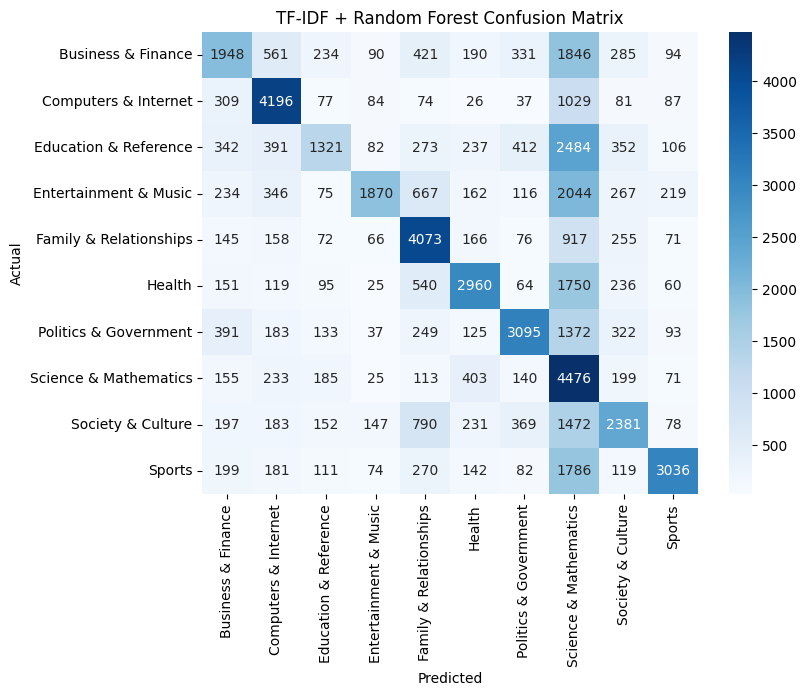

array([[1948,  561,  234,   90,  421,  190,  331, 1846,  285,   94],
       [ 309, 4196,   77,   84,   74,   26,   37, 1029,   81,   87],
       [ 342,  391, 1321,   82,  273,  237,  412, 2484,  352,  106],
       [ 234,  346,   75, 1870,  667,  162,  116, 2044,  267,  219],
       [ 145,  158,   72,   66, 4073,  166,   76,  917,  255,   71],
       [ 151,  119,   95,   25,  540, 2960,   64, 1750,  236,   60],
       [ 391,  183,  133,   37,  249,  125, 3095, 1372,  322,   93],
       [ 155,  233,  185,   25,  113,  403,  140, 4476,  199,   71],
       [ 197,  183,  152,  147,  790,  231,  369, 1472, 2381,   78],
       [ 199,  181,  111,   74,  270,  142,   82, 1786,  119, 3036]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score

# Train Random Forest
rf_tfidf = RandomForestClassifier(
    n_estimators=100,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

rf_tfidf.fit(X_train_tfidf, df_train['Class'])

# Predict
y_pred_tfidf_rf = rf_tfidf.predict(X_test_tfidf)

# Evaluate
print("=== TF-IDF + Random Forest ===")
print("Accuracy:", accuracy_score(df_test['Class'], y_pred_tfidf_rf))
print("F1-score (Macro):", f1_score(df_test['Class'], y_pred_tfidf_rf, average='macro'))
print("F1-score (Weighted):", f1_score(df_test['Class'], y_pred_tfidf_rf, average='weighted'))
print("Classification Report:\n", classification_report(df_test['Class'], y_pred_tfidf_rf))

# Confusion matrix
plot_confusion_matrix(df_test['Class'], y_pred_tfidf_rf, labels=np.unique(df_test['Class']),
                      title="TF-IDF + Random Forest Confusion Matrix")


TF-IDF + Logistic Regression

=== TF-IDF + Logistic Regression ===
Accuracy: 0.5942599043317388
F1-score (Macro): 0.590363760793741
F1-score (Weighted): 0.5903624925603782
Classification Report:
                         precision    recall  f1-score   support

    Business & Finance       0.50      0.41      0.45      6000
  Computers & Internet       0.72      0.77      0.74      6000
 Education & Reference       0.48      0.41      0.44      6000
 Entertainment & Music       0.53      0.55      0.54      6000
Family & Relationships       0.63      0.70      0.67      5999
                Health       0.64      0.68      0.66      6000
 Politics & Government       0.66      0.62      0.64      6000
 Science & Mathematics       0.55      0.65      0.60      6000
     Society & Culture       0.53      0.47      0.50      6000
                Sports       0.66      0.68      0.67      6000

              accuracy                           0.59     59999
             macro avg       0.59      0.59      0.59     59999


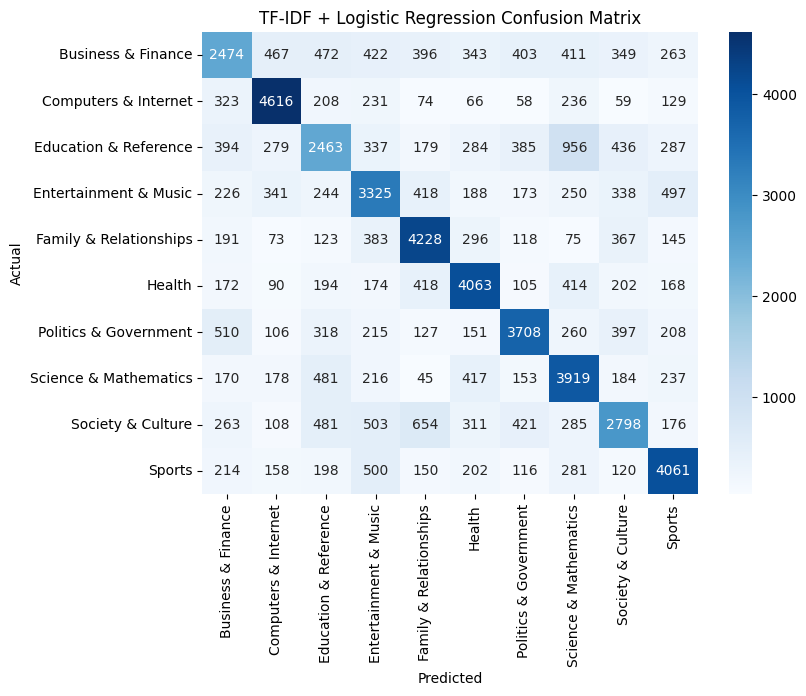

array([[2474,  467,  472,  422,  396,  343,  403,  411,  349,  263],
       [ 323, 4616,  208,  231,   74,   66,   58,  236,   59,  129],
       [ 394,  279, 2463,  337,  179,  284,  385,  956,  436,  287],
       [ 226,  341,  244, 3325,  418,  188,  173,  250,  338,  497],
       [ 191,   73,  123,  383, 4228,  296,  118,   75,  367,  145],
       [ 172,   90,  194,  174,  418, 4063,  105,  414,  202,  168],
       [ 510,  106,  318,  215,  127,  151, 3708,  260,  397,  208],
       [ 170,  178,  481,  216,   45,  417,  153, 3919,  184,  237],
       [ 263,  108,  481,  503,  654,  311,  421,  285, 2798,  176],
       [ 214,  158,  198,  500,  150,  202,  116,  281,  120, 4061]])

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr_tfidf = LogisticRegression(max_iter=2000, n_jobs=-1)
lr_tfidf.fit(X_train_tfidf, df_train['Class'])

# Predict
y_pred_tfidf_lr = lr_tfidf.predict(X_test_tfidf)

# Evaluate
print("=== TF-IDF + Logistic Regression ===")
print("Accuracy:", accuracy_score(df_test['Class'], y_pred_tfidf_lr))
print("F1-score (Macro):", f1_score(df_test['Class'], y_pred_tfidf_lr, average='macro'))
print("F1-score (Weighted):", f1_score(df_test['Class'], y_pred_tfidf_lr, average='weighted'))
print("Classification Report:\n", classification_report(df_test['Class'], y_pred_tfidf_lr))

# Confusion matrix
plot_confusion_matrix(df_test['Class'], y_pred_tfidf_lr, labels=np.unique(df_test['Class']),
                      title="TF-IDF + Logistic Regression Confusion Matrix")


TF-IDF + Naive Bayes

=== TF-IDF + Naive Bayes ===
Accuracy: 0.5783929732162203
F1-score (Macro): 0.5734935948413855
F1-score (Weighted): 0.5734925873860603
Classification Report:
                         precision    recall  f1-score   support

    Business & Finance       0.49      0.42      0.45      6000
  Computers & Internet       0.65      0.78      0.71      6000
 Education & Reference       0.48      0.38      0.43      6000
 Entertainment & Music       0.53      0.50      0.51      6000
Family & Relationships       0.55      0.75      0.63      5999
                Health       0.63      0.66      0.64      6000
 Politics & Government       0.66      0.59      0.62      6000
 Science & Mathematics       0.57      0.61      0.59      6000
     Society & Culture       0.51      0.47      0.49      6000
                Sports       0.70      0.62      0.66      6000

              accuracy                           0.58     59999
             macro avg       0.58      0.58      0.57     59999
       

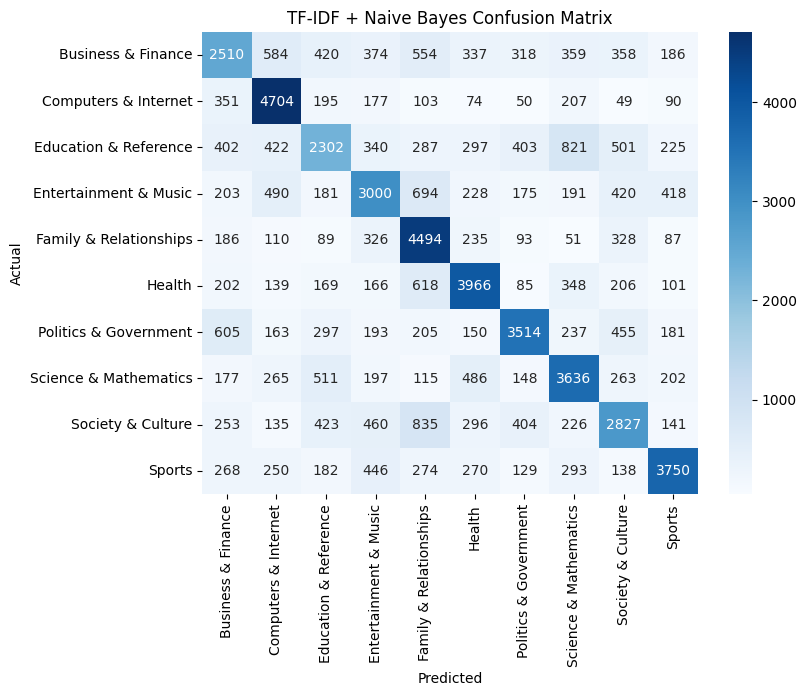

array([[2510,  584,  420,  374,  554,  337,  318,  359,  358,  186],
       [ 351, 4704,  195,  177,  103,   74,   50,  207,   49,   90],
       [ 402,  422, 2302,  340,  287,  297,  403,  821,  501,  225],
       [ 203,  490,  181, 3000,  694,  228,  175,  191,  420,  418],
       [ 186,  110,   89,  326, 4494,  235,   93,   51,  328,   87],
       [ 202,  139,  169,  166,  618, 3966,   85,  348,  206,  101],
       [ 605,  163,  297,  193,  205,  150, 3514,  237,  455,  181],
       [ 177,  265,  511,  197,  115,  486,  148, 3636,  263,  202],
       [ 253,  135,  423,  460,  835,  296,  404,  226, 2827,  141],
       [ 268,  250,  182,  446,  274,  270,  129,  293,  138, 3750]])

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, df_train['Class'])

# Predict
y_pred_tfidf_nb = nb_tfidf.predict(X_test_tfidf)

# Evaluate
print("=== TF-IDF + Naive Bayes ===")
print("Accuracy:", accuracy_score(df_test['Class'], y_pred_tfidf_nb))
print("F1-score (Macro):", f1_score(df_test['Class'], y_pred_tfidf_nb, average='macro'))
print("F1-score (Weighted):", f1_score(df_test['Class'], y_pred_tfidf_nb, average='weighted'))
print("Classification Report:\n", classification_report(df_test['Class'], y_pred_tfidf_nb))

# Confusion matrix
plot_confusion_matrix(df_test['Class'], y_pred_tfidf_nb, labels=np.unique(df_test['Class']),
                      title="TF-IDF + Naive Bayes Confusion Matrix")


TF-IDF + Deep Neural Network

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │       128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,058 (664.29 KB)

 Trainable params: 170,058 (664.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5214 - loss: 1.4643 - val_accuracy: 0.5761 - val_loss: 1.2903
Epoch 2/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.5918 - loss: 1.2493 - val_accuracy: 0.5847 - val_loss: 1.2654
Epoch 3/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.6081 - loss: 1.1940 - val_accuracy: 0.5896 - val_loss: 1.2533
Epoch 4/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.6241 - loss: 1.1368 - val_accuracy: 0.5891 - val_loss: 1.2577
Epoch 5/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.6399 - loss: 1.0896 - val_accuracy: 0.5844 - val_loss: 1.2768
Epoch 6/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.6543 - loss: 1.0479 - val_accuracy: 0.5808 - val_loss: 1.2935
Epoch 7/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.6653 - loss: 1.0093 - val_accuracy: 0.5791 - val_loss: 1.3126
Epoch 8/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.6762 - loss: 

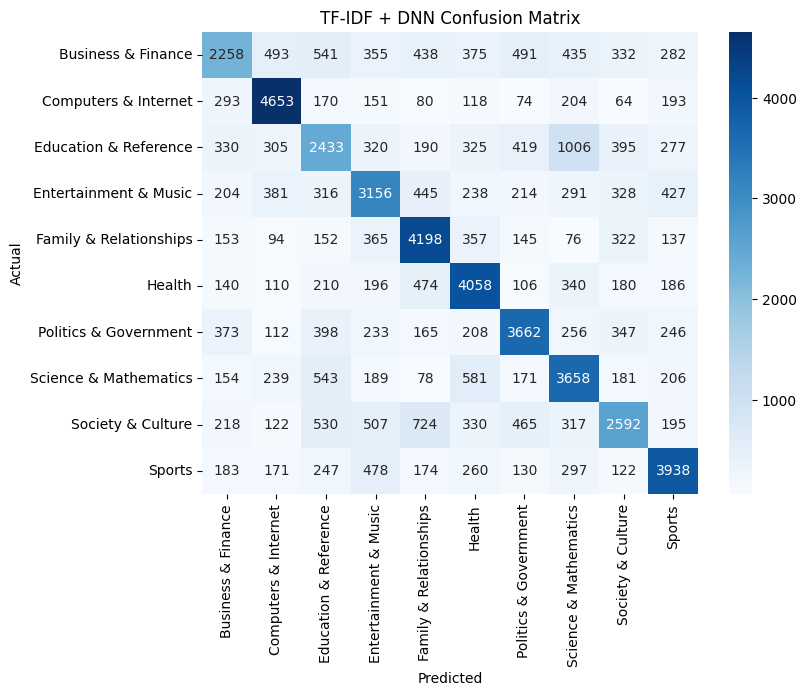

array([[2258,  493,  541,  355,  438,  375,  491,  435,  332,  282],
       [ 293, 4653,  170,  151,   80,  118,   74,  204,   64,  193],
       [ 330,  305, 2433,  320,  190,  325,  419, 1006,  395,  277],
       [ 204,  381,  316, 3156,  445,  238,  214,  291,  328,  427],
       [ 153,   94,  152,  365, 4198,  357,  145,   76,  322,  137],
       [ 140,  110,  210,  196,  474, 4058,  106,  340,  180,  186],
       [ 373,  112,  398,  233,  165,  208, 3662,  256,  347,  246],
       [ 154,  239,  543,  189,   78,  581,  171, 3658,  181,  206],
       [ 218,  122,  530,  507,  724,  330,  465,  317, 2592,  195],
       [ 183,  171,  247,  478,  174,  260,  130,  297,  122, 3938]])

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(df_train['Class'])
y_test_int  = le.transform(df_test['Class'])

y_train_onehot = to_categorical(y_train_int)
y_test_onehot  = to_categorical(y_test_int)

# Convert TF-IDF sparse to dense and reduce dimensionality using TruncatedSVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=500, random_state=42)
X_train_tfidf_dense = svd.fit_transform(X_train_tfidf)
X_test_tfidf_dense  = svd.transform(X_test_tfidf)

# Build DNN on GPU
with tf.device('/GPU:0'):
    model_tfidf_dnn = Sequential([
        Dense(256, activation="relu", input_shape=(X_train_tfidf_dense.shape[1],)),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_tfidf_dnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model_tfidf_dnn.summary()

    # Train model
    history_tfidf_dnn = model_tfidf_dnn.fit(
        X_train_tfidf_dense, y_train_onehot,
        epochs=10, batch_size=64, validation_split=0.2, verbose=1
    )

    # Predict
    y_pred_tfidf_dnn = model_tfidf_dnn.predict(X_test_tfidf_dense, verbose=0).argmax(axis=1)

# Evaluate
print("=== TF-IDF + Deep Neural Network ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_tfidf_dnn))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_tfidf_dnn, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_tfidf_dnn, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_tfidf_dnn, target_names=le.classes_))

# Confusion matrix
plot_confusion_matrix(y_test_int, y_pred_tfidf_dnn, labels=le.classes_,
                      title="TF-IDF + DNN Confusion Matrix")


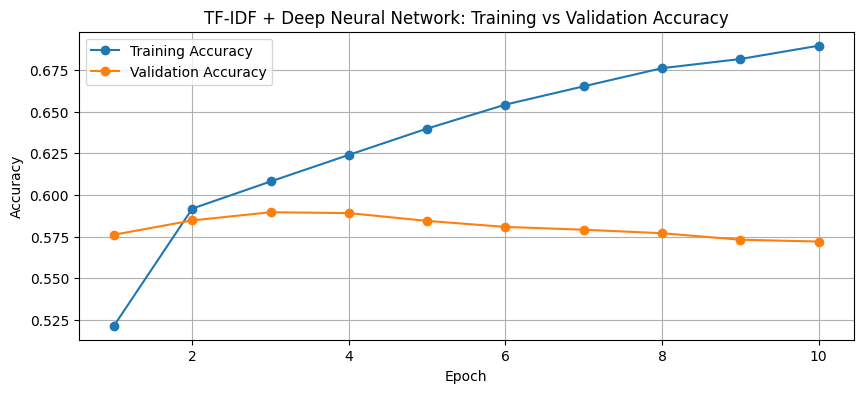

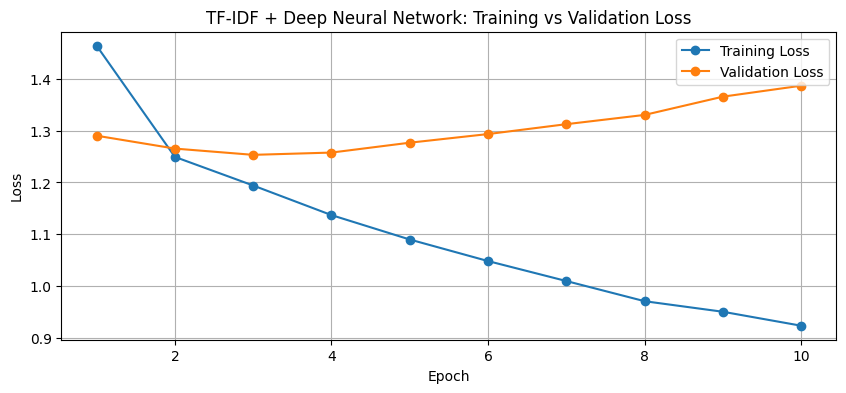

In [22]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))  # 10 epochs

# Accuracy
train_acc = [0.5214, 0.5918, 0.6081, 0.6241, 0.6399, 0.6543, 0.6653, 0.6762, 0.6817, 0.6897]
val_acc   = [0.5761, 0.5847, 0.5896, 0.5891, 0.5844, 0.5808, 0.5791, 0.5770, 0.5731, 0.5720]

# Loss
train_loss = [1.4643, 1.2493, 1.1940, 1.1368, 1.0896, 1.0479, 1.0093, 0.9703, 0.9499, 0.9229]
val_loss   = [1.2903, 1.2654, 1.2533, 1.2577, 1.2768, 1.2935, 1.3126, 1.3305, 1.3658, 1.3870]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('TF-IDF + Deep Neural Network: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('TF-IDF + Deep Neural Network: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


save

In [ ]:
# === TF-IDF + Random Forest ===
TFIDF_RF_accuracy = 0.48927482124702076
TFIDF_RF_f1_macro = 0.4967999033020708
TFIDF_RF_f1_weighted = 0.496798103333815

# === TF-IDF + Logistic Regression ===
TFIDF_LR_accuracy = 0.5942599043317388
TFIDF_LR_f1_macro = 0.590363760793741
TFIDF_LR_f1_weighted = 0.5903624925603782

# === TF-IDF + Naive Bayes ===
TFIDF_NB_accuracy = 0.5783929732162203
TFIDF_NB_f1_macro = 0.5734935948413855
TFIDF_NB_f1_weighted = 0.5734925873860603

# === TF-IDF + Deep Neural Network ===
TFIDF_DNN_accuracy = 0.57677627960466
TFIDF_DNN_f1_macro = 0.5714644492032195
TFIDF_DNN_f1_weighted = 0.5714631804284853


#Experiments with GloVe Representation

In [ ]:
'''
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Embedding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

import pandas as pd'''

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten

GloVe+Deep Neural Network


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 186s 26ms/step - accuracy: 0.5577 - loss: 1.3482 - val_accuracy: 0.6398 - val_loss: 1.1119
Epoch 2/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 159s 20ms/step - accuracy: 0.6476 - loss: 1.0878 - val_accuracy: 0.6482 - val_loss: 1.0950
Epoch 3/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 148s 21ms/step - accuracy: 0.6694 - loss: 1.0182 - val_accuracy: 0.6440 - val_loss: 1.0989
Epoch 4/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 151s 22ms/step - accuracy: 0.6853 - loss: 0.9643 - val_accuracy: 0.6457 - val_loss: 1.1023
Epoch 5/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 193s 20ms/step - accuracy: 0.7018 - loss: 0.9135 - val_accuracy: 0.6428 - val_loss: 1.1167
Epoch 6/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 149s 21ms/step - accuracy: 0.7125 - loss: 0.8758 - val_accuracy: 0.6413 - val_loss: 1.1381
Epoch 7/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 197s 20ms/step - accuracy: 0.7236 - loss: 0.8417 - val_accuracy: 0.6398 - val_loss: 1.1543
Epoch 8/8
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 205s 21ms/step - accuracy: 0.7292 -

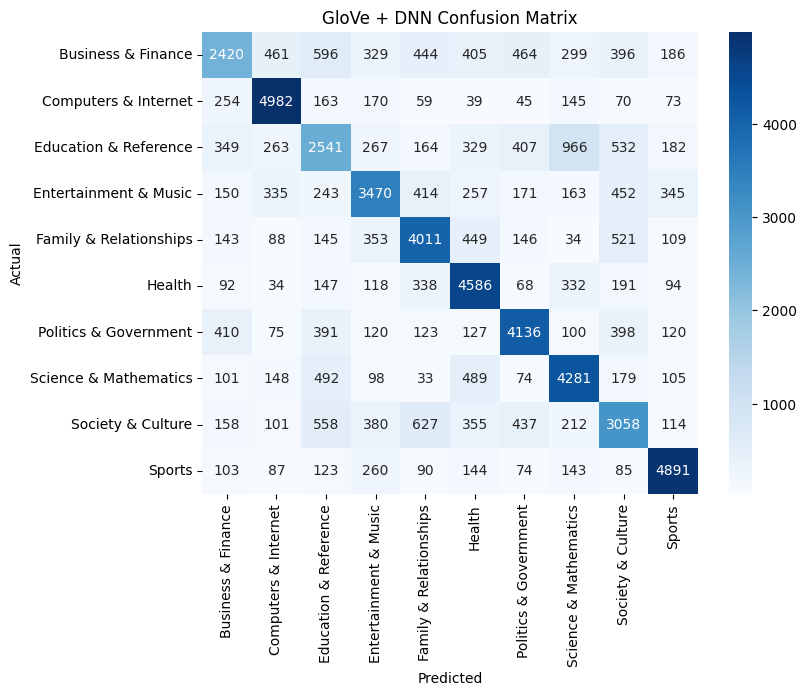

array([[2420,  461,  596,  329,  444,  405,  464,  299,  396,  186],
       [ 254, 4982,  163,  170,   59,   39,   45,  145,   70,   73],
       [ 349,  263, 2541,  267,  164,  329,  407,  966,  532,  182],
       [ 150,  335,  243, 3470,  414,  257,  171,  163,  452,  345],
       [ 143,   88,  145,  353, 4011,  449,  146,   34,  521,  109],
       [  92,   34,  147,  118,  338, 4586,   68,  332,  191,   94],
       [ 410,   75,  391,  120,  123,  127, 4136,  100,  398,  120],
       [ 101,  148,  492,   98,   33,  489,   74, 4281,  179,  105],
       [ 158,  101,  558,  380,  627,  355,  437,  212, 3058,  114],
       [ 103,   87,  123,  260,   90,  144,   74,  143,   85, 4891]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten

# DNN does not use RNN layers; flatten embeddings
with tf.device('/GPU:0'):
    model_glove_dnn = Sequential([
        Embedding(input_dim=num_words, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH, trainable=False),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_glove_dnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model_glove_dnn.summary()

    # Train
    history_glove_dnn = model_glove_dnn.fit(
        X_train_pad, y_train_onehot,
        epochs=8, batch_size=32, validation_split=0.2, verbose=1
    )

    # Predict
    y_pred_glove_dnn = model_glove_dnn.predict(X_test_pad, verbose=0).argmax(axis=1)

# Evaluate
print("=== GloVe + DNN ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_glove_dnn))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_glove_dnn, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_glove_dnn, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_glove_dnn, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_glove_dnn, labels=le.classes_, title="GloVe + DNN Confusion Matrix")


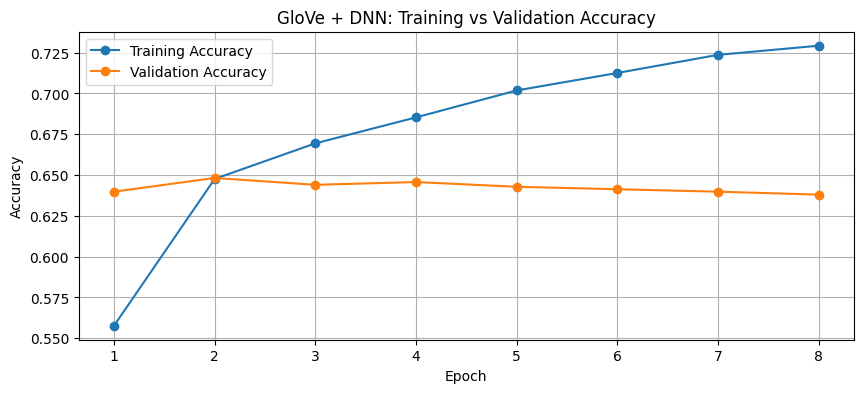

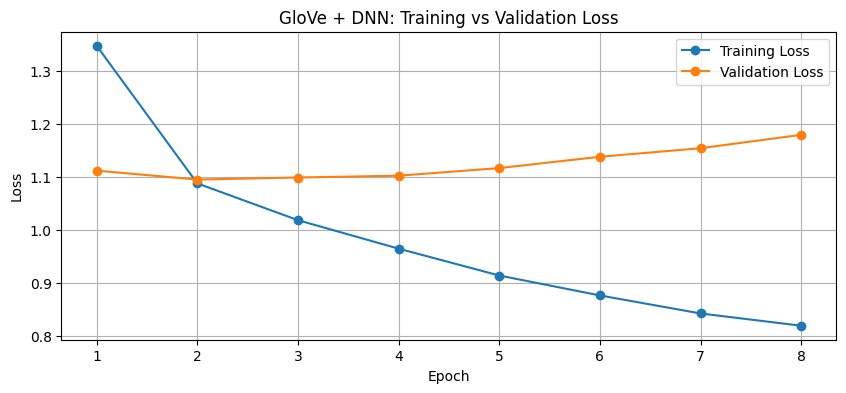

In [14]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 9))  # 8 epochs

# Accuracy
train_acc = [0.5577, 0.6476, 0.6694, 0.6853, 0.7018, 0.7125, 0.7236, 0.7292]
val_acc   = [0.6398, 0.6482, 0.6440, 0.6457, 0.6428, 0.6413, 0.6398, 0.6380]

# Loss
train_loss = [1.3482, 1.0878, 1.0182, 0.9643, 0.9135, 0.8758, 0.8417, 0.8185]
val_loss   = [1.1119, 1.0950, 1.0989, 1.1023, 1.1167, 1.1381, 1.1543, 1.1796]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('GloVe + DNN: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('GloVe + DNN: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


GloVe+ SimpleRNN

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/7
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 439s 62ms/step - accuracy: 0.1150 - loss: 2.3223 - val_accuracy: 0.1276 - val_loss: 2.2625
Epoch 2/7
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 379s 53ms/step - accuracy: 0.1745 - loss: 2.2767 - val_accuracy: 0.1585 - val_loss: 2.2130
Epoch 3/7
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 377s 52ms/step - accuracy: 0.2145 - loss: 2.1258 - val_accuracy: 0.1933 - val_loss: 2.1825
Epoch 4/7
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 363s 52ms/step - accuracy: 0.2458 - loss: 2.0738 - val_accuracy: 0.1905 - val_loss: 2.1814
Epoch 5/7
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 384s 52ms/step - accuracy: 0.2569 - loss: 2.0359 - val_accuracy: 0.1929 - val_loss: 2.1095
Epoch 6/7
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 366s 52ms/step - accuracy: 0.2733 - loss: 2.0012 - val_accuracy: 0.2306 - val_loss: 2.1108
Epoch 7/7
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 406s 56ms/step - accuracy: 0.2774 - loss: 40.4011 - val_accuracy: 0.2359 - val_loss: 2.0884
=== GloVe + SimpleRNN (Optimized) ===
Accuracy: 0.2372706211770196
F1-score

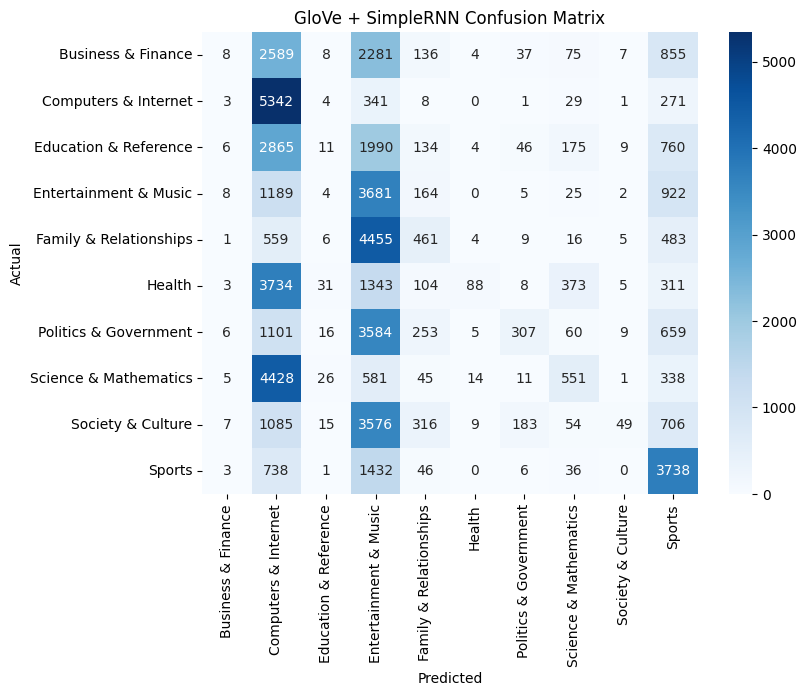

array([[   8, 2589,    8, 2281,  136,    4,   37,   75,    7,  855],
       [   3, 5342,    4,  341,    8,    0,    1,   29,    1,  271],
       [   6, 2865,   11, 1990,  134,    4,   46,  175,    9,  760],
       [   8, 1189,    4, 3681,  164,    0,    5,   25,    2,  922],
       [   1,  559,    6, 4455,  461,    4,    9,   16,    5,  483],
       [   3, 3734,   31, 1343,  104,   88,    8,  373,    5,  311],
       [   6, 1101,   16, 3584,  253,    5,  307,   60,    9,  659],
       [   5, 4428,   26,  581,   45,   14,   11,  551,    1,  338],
       [   7, 1085,   15, 3576,  316,    9,  183,   54,   49,  706],
       [   3,  738,    1, 1432,   46,    0,    6,   36,    0, 3738]])

In [ ]:
with tf.device('/GPU:0'):
    model_glove_rnn = Sequential([
        Embedding(input_dim=num_words, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH, trainable=False),
        SimpleRNN(64, return_sequences=True, activation="relu", dropout=0.2, recurrent_dropout=0.2),
        SimpleRNN(32, activation="relu", dropout=0.2, recurrent_dropout=0.2),
        Dropout(0.3),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_glove_rnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model_glove_rnn.summary()

    history_glove_rnn = model_glove_rnn.fit(
        X_train_pad, y_train_onehot,
        epochs=7, batch_size=32, validation_split=0.2, verbose=1
    )

    y_pred_glove_rnn = model_glove_rnn.predict(X_test_pad, verbose=0).argmax(axis=1)

print("=== GloVe + SimpleRNN (Optimized) ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_glove_rnn))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_glove_rnn, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_glove_rnn, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_glove_rnn, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_glove_rnn, labels=le.classes_, title="GloVe + SimpleRNN Confusion Matrix")


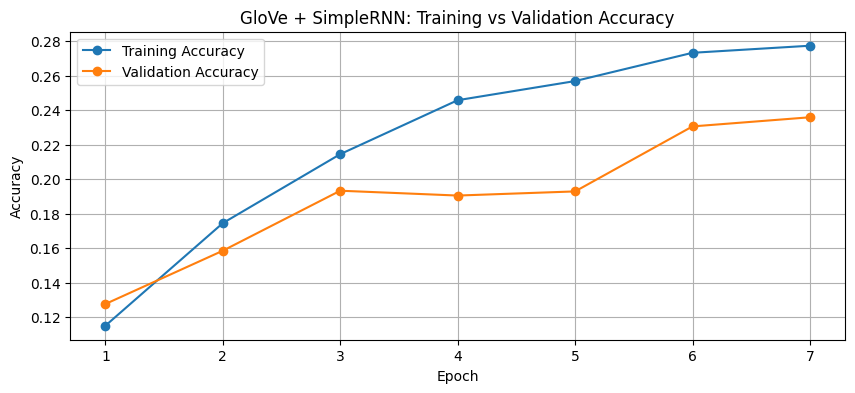

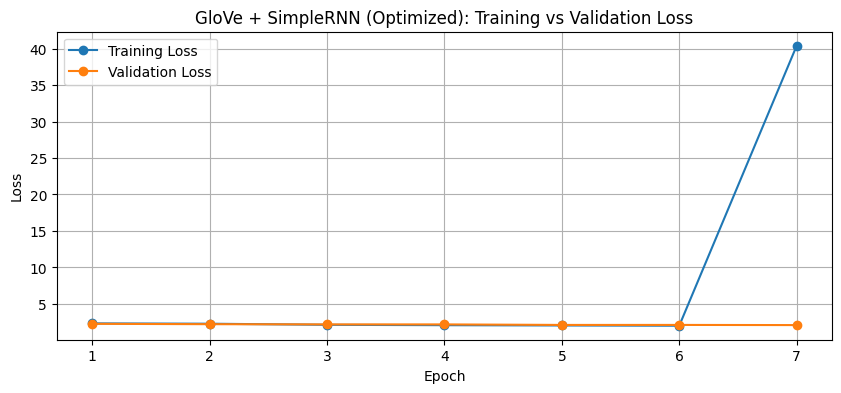

In [16]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 8))  # 7 epochs

# Accuracy
train_acc = [0.1150, 0.1745, 0.2145, 0.2458, 0.2569, 0.2733, 0.2774]
val_acc   = [0.1276, 0.1585, 0.1933, 0.1905, 0.1929, 0.2306, 0.2359]

# Loss
train_loss = [2.3223, 2.2767, 2.1258, 2.0738, 2.0359, 2.0012, 40.4011]  # Note: last value is unusually high
val_loss   = [2.2625, 2.2130, 2.1825, 2.1814, 2.1095, 2.1108, 2.0884]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('GloVe + SimpleRNN: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('GloVe + SimpleRNN (Optimized): Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

GloVe+GRU

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 785s 111ms/step - accuracy: 0.5075 - loss: 1.4416 - val_accuracy: 0.6849 - val_loss: 0.9978
Epoch 2/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 828s 118ms/step - accuracy: 0.6846 - loss: 1.0043 - val_accuracy: 0.6970 - val_loss: 0.9738
Epoch 3/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 899s 124ms/step - accuracy: 0.7015 - loss: 0.9550 - val_accuracy: 0.7010 - val_loss: 0.9694
Epoch 4/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 880s 118ms/step - accuracy: 0.7067 - loss: 0.9319 - val_accuracy: 0.7030 - val_loss: 0.9480
Epoch 5/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 860s 117ms/step - accuracy: 0.7106 - loss: 0.9180 - val_accuracy: 0.7033 - val_loss: 0.9414
Epoch 6/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 821s 112ms/step - accuracy: 0.7157 - loss: 0.9035 - val_accuracy: 0.7037 - val_loss: 0.9450
Epoch 7/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 853s 119ms/step - accuracy: 0.7177 - loss: 0.8936 - val_accuracy: 0.7020 - val_loss: 0.9366
Epoch 8/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 845s 116ms/step - ac

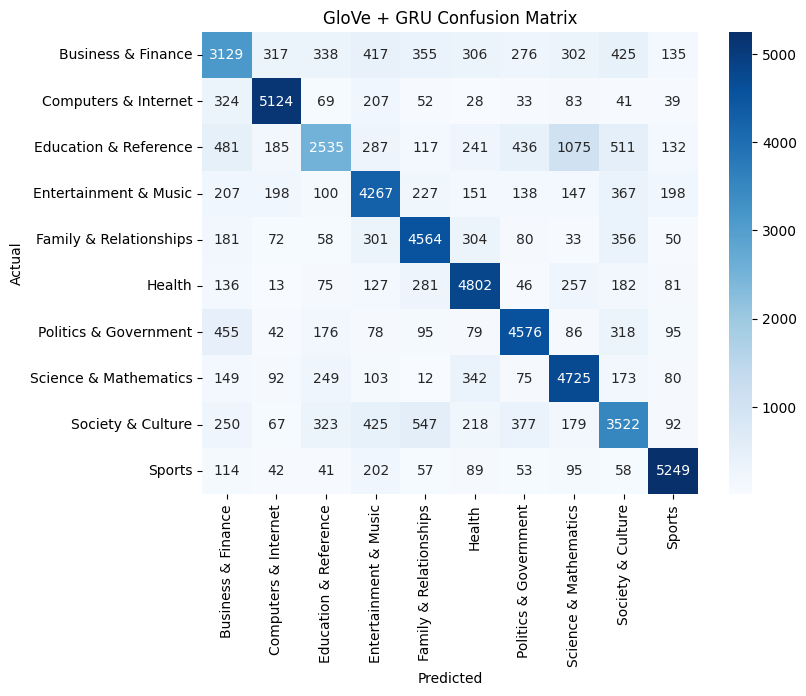

array([[3129,  317,  338,  417,  355,  306,  276,  302,  425,  135],
       [ 324, 5124,   69,  207,   52,   28,   33,   83,   41,   39],
       [ 481,  185, 2535,  287,  117,  241,  436, 1075,  511,  132],
       [ 207,  198,  100, 4267,  227,  151,  138,  147,  367,  198],
       [ 181,   72,   58,  301, 4564,  304,   80,   33,  356,   50],
       [ 136,   13,   75,  127,  281, 4802,   46,  257,  182,   81],
       [ 455,   42,  176,   78,   95,   79, 4576,   86,  318,   95],
       [ 149,   92,  249,  103,   12,  342,   75, 4725,  173,   80],
       [ 250,   67,  323,  425,  547,  218,  377,  179, 3522,   92],
       [ 114,   42,   41,  202,   57,   89,   53,   95,   58, 5249]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, LSTM, SimpleRNN, Bidirectional, Dense, Dropout


with tf.device('/GPU:0'):
    model_glove_gru = Sequential([
        Embedding(input_dim=num_words, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH, trainable=False),
        GRU(64, return_sequences=True, activation="relu"),
        GRU(32, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_glove_gru.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model_glove_gru.summary()

    history_glove_gru = model_glove_gru.fit(
        X_train_pad, y_train_onehot,
        epochs=10, batch_size=32, validation_split=0.2, verbose=1
    )

    y_pred_glove_gru = model_glove_gru.predict(X_test_pad, verbose=0).argmax(axis=1)

print("=== GloVe + GRU ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_glove_gru))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_glove_gru, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_glove_gru, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_glove_gru, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_glove_gru, labels=le.classes_, title="GloVe + GRU Confusion Matrix")


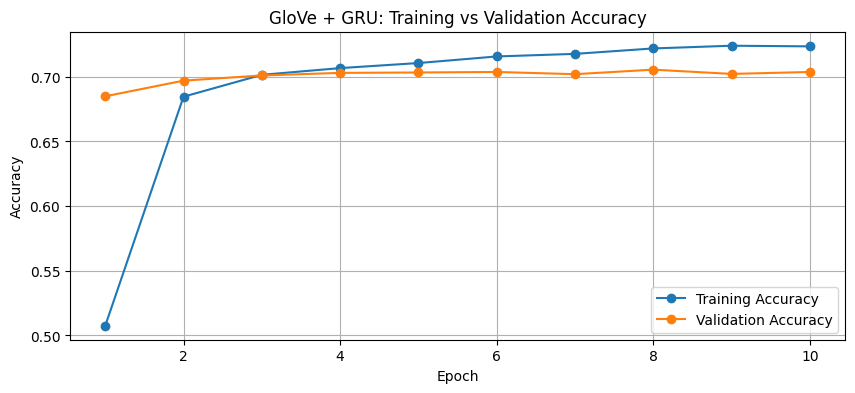

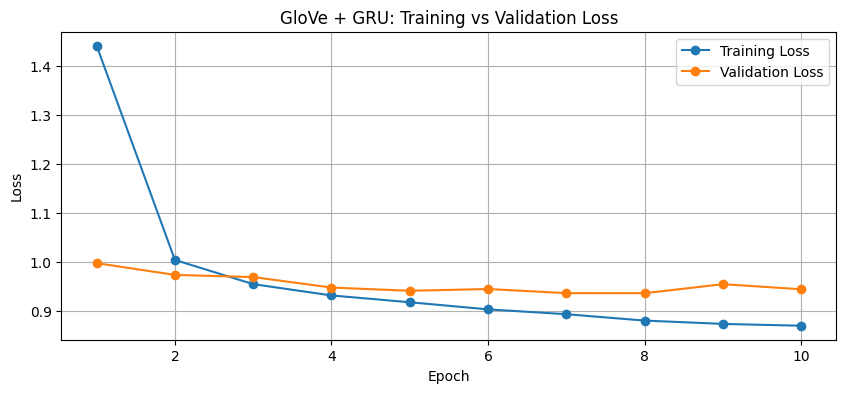

In [17]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))  # 10 epochs

# Accuracy
train_acc = [0.5075, 0.6846, 0.7015, 0.7067, 0.7106, 0.7157, 0.7177, 0.7219, 0.7240, 0.7235]
val_acc   = [0.6849, 0.6970, 0.7010, 0.7030, 0.7033, 0.7037, 0.7020, 0.7055, 0.7022, 0.7037]

# Loss
train_loss = [1.4416, 1.0043, 0.9550, 0.9319, 0.9180, 0.9035, 0.8936, 0.8806, 0.8738, 0.8701]
val_loss   = [0.9978, 0.9738, 0.9694, 0.9480, 0.9414, 0.9450, 0.9366, 0.9365, 0.9549, 0.9445]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('GloVe + GRU: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('GloVe + GRU: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


GloVe+LSTM

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 68s 16ms/step - accuracy: 0.2349 - loss: 2.0633 - val_accuracy: 0.3222 - val_loss: 1.8773
Epoch 2/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 67s 14ms/step - accuracy: 0.4724 - loss: 1.5394 - val_accuracy: 0.6657 - val_loss: 1.0592
Epoch 3/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - accuracy: 0.6695 - loss: 1.0564 - val_accuracy: 0.6889 - val_loss: 0.9714
Epoch 4/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - accuracy: 0.6909 - loss: 0.9763 - val_accuracy: 0.6951 - val_loss: 0.9429
Epoch 5/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.7057 - loss: 0.9294 - val_accuracy: 0.7039 - val_loss: 0.9145
Epoch 6/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.7127 - loss: 0.9047 - val_accuracy: 0.7066 - val_loss: 0.9064
Epoch 7/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 86s 15ms/step - accuracy: 0.7180 - loss: 0.8838 - val_accuracy: 0.7078 - val_loss: 0.9000
Epoch 8/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.7224 - loss: 0

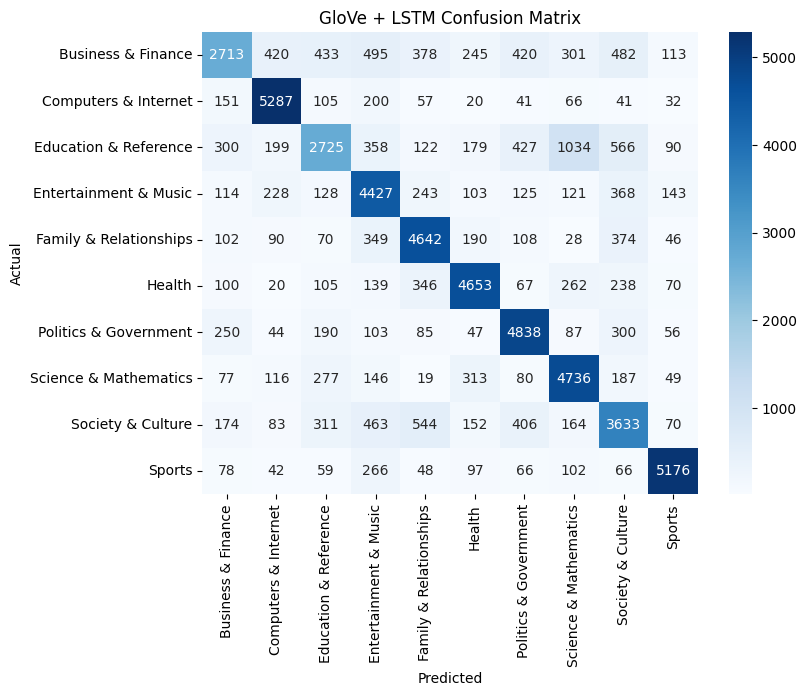

array([[2713,  420,  433,  495,  378,  245,  420,  301,  482,  113],
       [ 151, 5287,  105,  200,   57,   20,   41,   66,   41,   32],
       [ 300,  199, 2725,  358,  122,  179,  427, 1034,  566,   90],
       [ 114,  228,  128, 4427,  243,  103,  125,  121,  368,  143],
       [ 102,   90,   70,  349, 4642,  190,  108,   28,  374,   46],
       [ 100,   20,  105,  139,  346, 4653,   67,  262,  238,   70],
       [ 250,   44,  190,  103,   85,   47, 4838,   87,  300,   56],
       [  77,  116,  277,  146,   19,  313,   80, 4736,  187,   49],
       [ 174,   83,  311,  463,  544,  152,  406,  164, 3633,   70],
       [  78,   42,   59,  266,   48,   97,   66,  102,   66, 5176]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

with tf.device('/GPU:0'):
    model_glove_lstm = Sequential([
        Embedding(input_dim=num_words, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH, trainable=False),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dropout(0.3),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_glove_lstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model_glove_lstm.summary()

    history_glove_lstm = model_glove_lstm.fit(
        X_train_pad, y_train_onehot,
        epochs=8, batch_size=64, validation_split=0.2, verbose=1
    )

    y_pred_glove_lstm = model_glove_lstm.predict(X_test_pad, verbose=0).argmax(axis=1)

print("=== GloVe + LSTM ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_glove_lstm))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_glove_lstm, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_glove_lstm, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_glove_lstm, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_glove_lstm, labels=le.classes_, title="GloVe + LSTM Confusion Matrix")


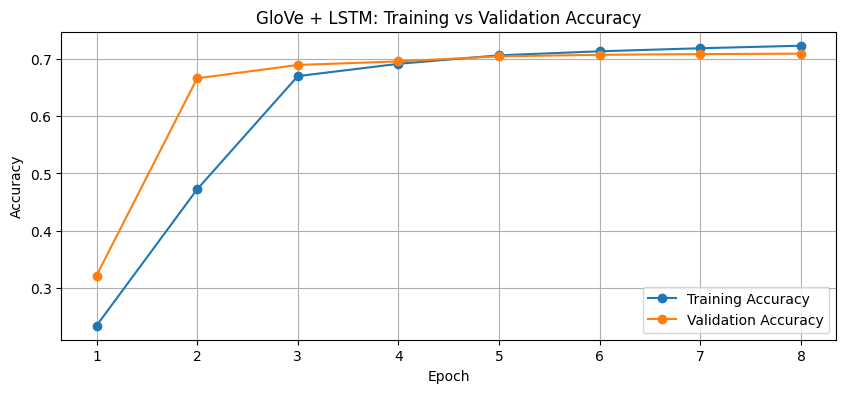

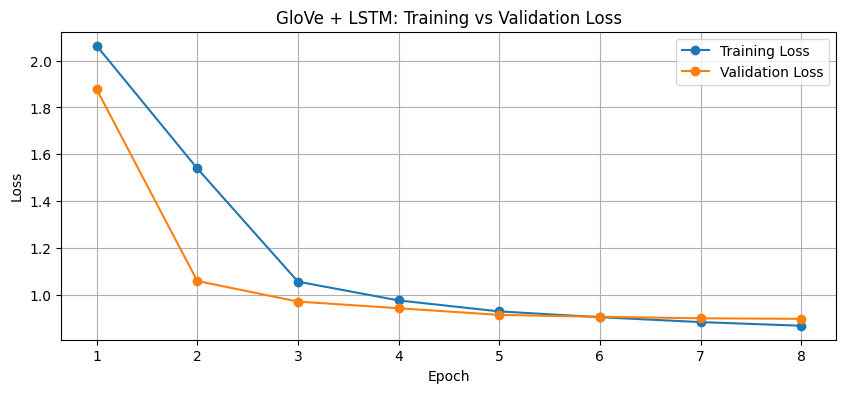

In [18]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 9))  # 8 epochs

# Accuracy
train_acc = [0.2349, 0.4724, 0.6695, 0.6909, 0.7057, 0.7127, 0.7180, 0.7224]
val_acc   = [0.3222, 0.6657, 0.6889, 0.6951, 0.7039, 0.7066, 0.7078, 0.7086]

# Loss
train_loss = [2.0633, 1.5394, 1.0564, 0.9763, 0.9294, 0.9047, 0.8838, 0.8683]
val_loss   = [1.8773, 1.0592, 0.9714, 0.9429, 0.9145, 0.9064, 0.9000, 0.8977]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('GloVe + LSTM: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('GloVe + LSTM: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


GloVe+ Bidirectional SimpleRNN

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 135s 36ms/step - accuracy: 0.5582 - loss: 1.3804 - val_accuracy: 0.6895 - val_loss: 1.0060
Epoch 2/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 136s 36ms/step - accuracy: 0.7057 - loss: 0.9796 - val_accuracy: 0.6809 - val_loss: 1.0330
Epoch 3/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 139s 35ms/step - accuracy: 0.7150 - loss: 0.9467 - val_accuracy: 0.7008 - val_loss: 0.9655
Epoch 4/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 142s 35ms/step - accuracy: 0.7370 - loss: 0.8682 - val_accuracy: 0.6981 - val_loss: 0.9706
Epoch 5/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 144s 36ms/step - accuracy: 0.7474 - loss: 0.8269 - val_accuracy: 0.6952 - val_loss: 0.9915
Epoch 6/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 139s 35ms/step - accuracy: 0.7596 - loss: 0.7845 - val_accuracy: 0.6935 - val_loss: 1.0094
Epoch 7/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 142s 35ms/step - accuracy: 0.7720 - loss: 0.7421 - val_accuracy: 0.6935 - val_loss: 1.0320
Epoch 8/8
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 159s 40ms/step - accuracy: 0.7818 -

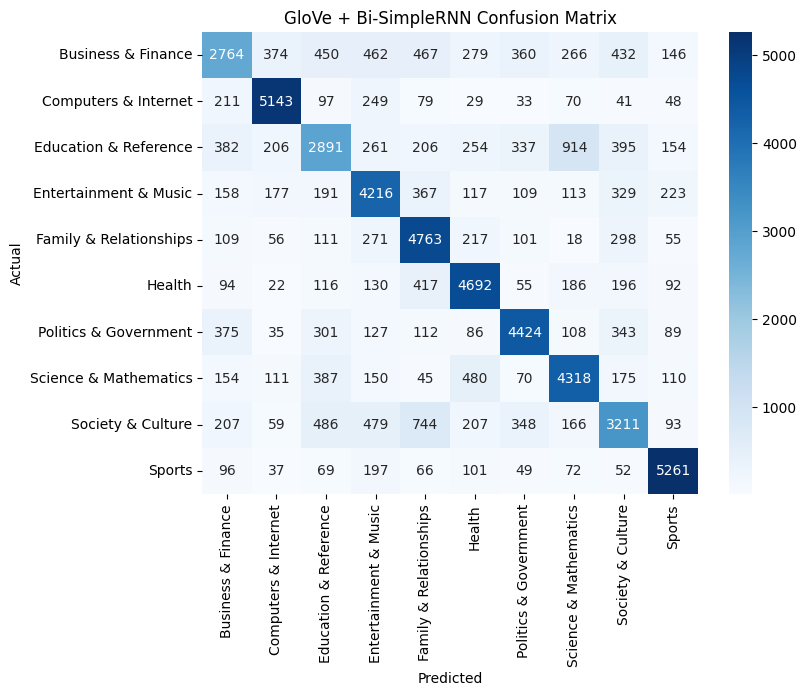

array([[2764,  374,  450,  462,  467,  279,  360,  266,  432,  146],
       [ 211, 5143,   97,  249,   79,   29,   33,   70,   41,   48],
       [ 382,  206, 2891,  261,  206,  254,  337,  914,  395,  154],
       [ 158,  177,  191, 4216,  367,  117,  109,  113,  329,  223],
       [ 109,   56,  111,  271, 4763,  217,  101,   18,  298,   55],
       [  94,   22,  116,  130,  417, 4692,   55,  186,  196,   92],
       [ 375,   35,  301,  127,  112,   86, 4424,  108,  343,   89],
       [ 154,  111,  387,  150,   45,  480,   70, 4318,  175,  110],
       [ 207,   59,  486,  479,  744,  207,  348,  166, 3211,   93],
       [  96,   37,   69,  197,   66,  101,   49,   72,   52, 5261]])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout
import tensorflow as tf

with tf.device('/GPU:0'):
    model_glove_birnn = Sequential([
        Embedding(input_dim=num_words, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH, trainable=True),
        Bidirectional(SimpleRNN(128, return_sequences=True, activation="relu")),
        Bidirectional(SimpleRNN(64, activation="relu")),
        Dropout(0.3),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_glove_birnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model_glove_birnn.summary()

    history_glove_birnn = model_glove_birnn.fit(
        X_train_pad, y_train_onehot,
        epochs=8, batch_size=64, validation_split=0.2, verbose=1
    )

    y_pred_glove_birnn = model_glove_birnn.predict(X_test_pad, verbose=0).argmax(axis=1)

print("=== GloVe + Bi-SimpleRNN ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_glove_birnn))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_glove_birnn, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_glove_birnn, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_glove_birnn, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_glove_birnn, labels=le.classes_, title="GloVe + Bi-SimpleRNN Confusion Matrix")


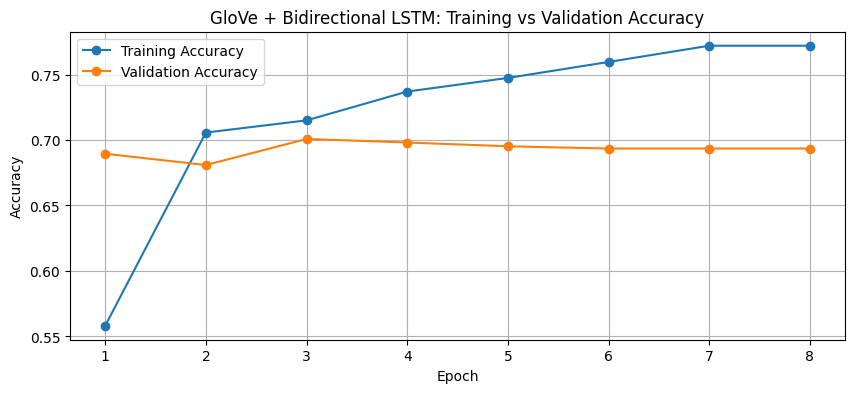

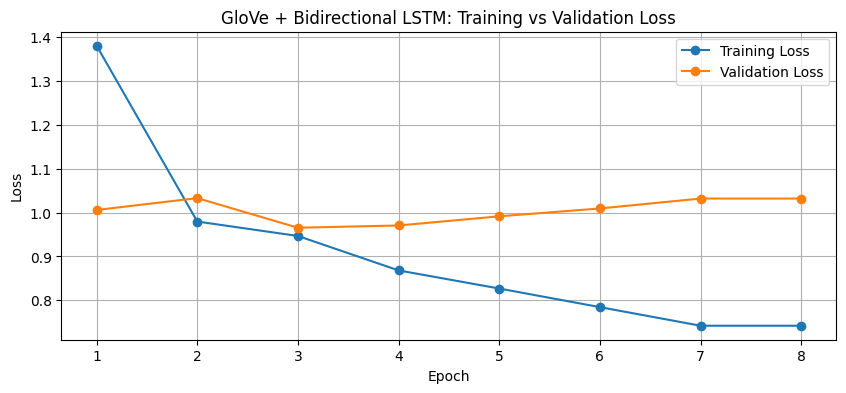

In [19]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 9))  # 8 epochs

# Accuracy
train_acc = [0.5582, 0.7057, 0.7150, 0.7370, 0.7474, 0.7596, 0.7720, 0.7720]  # last value repeated if missing
val_acc   = [0.6895, 0.6809, 0.7008, 0.6981, 0.6952, 0.6935, 0.6935, 0.6935]

# Loss
train_loss = [1.3804, 0.9796, 0.9467, 0.8682, 0.8269, 0.7845, 0.7421, 0.7421]
val_loss   = [1.0060, 1.0330, 0.9655, 0.9706, 0.9915, 1.0094, 1.0320, 1.0320]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('GloVe + Bidirectional LSTM: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('GloVe + Bidirectional LSTM: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


GloVe+Bidirectional GRU

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 167s 45ms/step - accuracy: 0.6079 - loss: 1.2331 - val_accuracy: 0.7111 - val_loss: 0.9073
Epoch 2/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 149s 43ms/step - accuracy: 0.7291 - loss: 0.8776 - val_accuracy: 0.7195 - val_loss: 0.8713
Epoch 3/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 153s 44ms/step - accuracy: 0.7508 - loss: 0.7899 - val_accuracy: 0.7192 - val_loss: 0.8742
Epoch 4/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 198s 43ms/step - accuracy: 0.7682 - loss: 0.7247 - val_accuracy: 0.7159 - val_loss: 0.9060
Epoch 5/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 149s 43ms/step - accuracy: 0.7852 - loss: 0.6641 - val_accuracy: 0.7107 - val_loss: 0.9591
Epoch 6/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 202s 43ms/step - accuracy: 0.8018 - loss: 0.6021 - val_accuracy: 0.7064 - val_loss: 1.0048
Epoch 7/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 202s 43ms/step - accuracy: 0.8217 - loss: 0.5361 - val_accuracy: 0.6974 - val_loss: 1.1348
Epoch 8/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 149s 43ms/step - accuracy: 

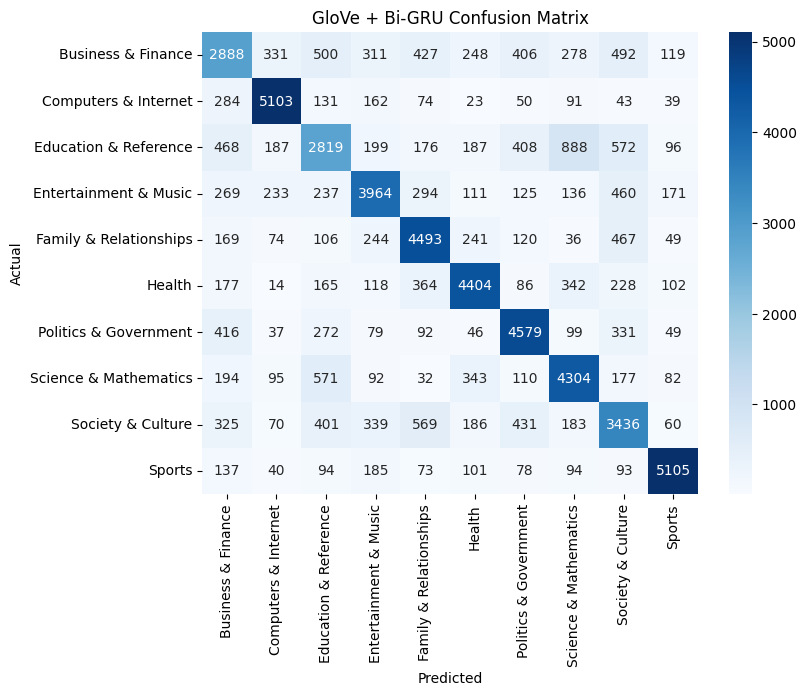

array([[2888,  331,  500,  311,  427,  248,  406,  278,  492,  119],
       [ 284, 5103,  131,  162,   74,   23,   50,   91,   43,   39],
       [ 468,  187, 2819,  199,  176,  187,  408,  888,  572,   96],
       [ 269,  233,  237, 3964,  294,  111,  125,  136,  460,  171],
       [ 169,   74,  106,  244, 4493,  241,  120,   36,  467,   49],
       [ 177,   14,  165,  118,  364, 4404,   86,  342,  228,  102],
       [ 416,   37,  272,   79,   92,   46, 4579,   99,  331,   49],
       [ 194,   95,  571,   92,   32,  343,  110, 4304,  177,   82],
       [ 325,   70,  401,  339,  569,  186,  431,  183, 3436,   60],
       [ 137,   40,   94,  185,   73,  101,   78,   94,   93, 5105]])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense, Dropout

with tf.device('/GPU:0'):
    model_glove_bigru = Sequential([
        Embedding(input_dim=num_words, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH, trainable=True),
        Bidirectional(GRU(128, return_sequences=True, activation="relu")),
        Bidirectional(GRU(64, activation="relu")),
        Dropout(0.3),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_glove_bigru.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model_glove_bigru.summary()

    history_glove_bigru = model_glove_bigru.fit(
        X_train_pad, y_train_onehot,
        epochs=10, batch_size=64, validation_split=0.2, verbose=1
    )

    y_pred_glove_bigru = model_glove_bigru.predict(X_test_pad, verbose=0).argmax(axis=1)

print("=== GloVe + Bi-GRU ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_glove_bigru))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_glove_bigru, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_glove_bigru, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_glove_bigru, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_glove_bigru, labels=le.classes_, title="GloVe + Bi-GRU Confusion Matrix")


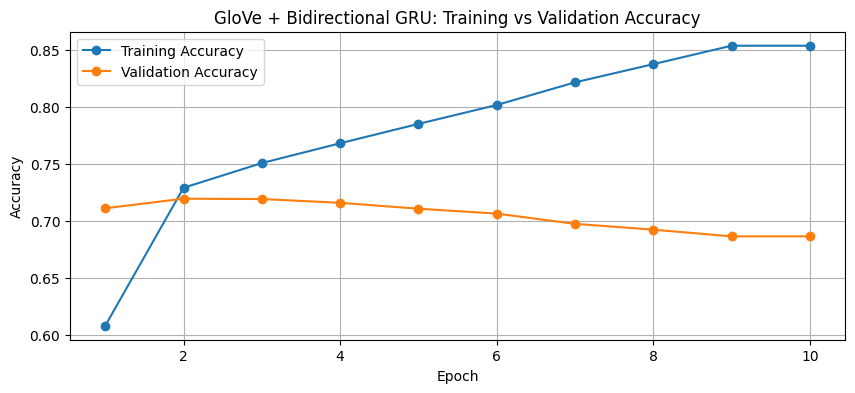

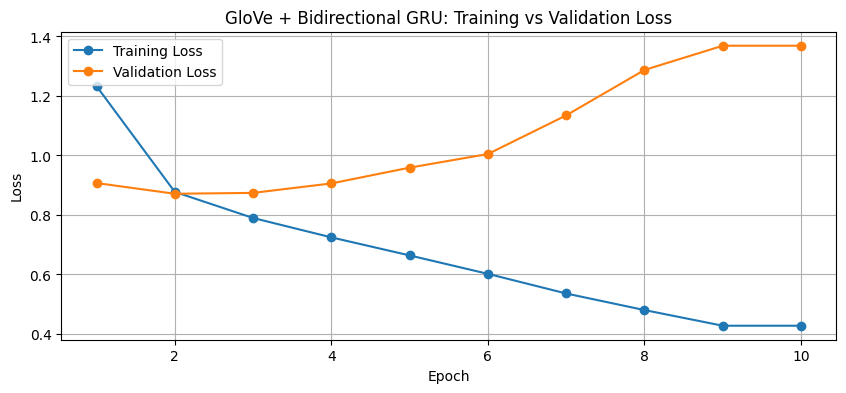

In [20]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))  # 10 epochs

# Accuracy
train_acc = [0.6079, 0.7291, 0.7508, 0.7682, 0.7852, 0.8018, 0.8217, 0.8377, 0.8539, 0.8539]  # last value repeated if missing
val_acc   = [0.7111, 0.7195, 0.7192, 0.7159, 0.7107, 0.7064, 0.6974, 0.6923, 0.6864, 0.6864]

# Loss
train_loss = [1.2331, 0.8776, 0.7899, 0.7247, 0.6641, 0.6021, 0.5361, 0.4804, 0.4278, 0.4278]
val_loss   = [0.9073, 0.8713, 0.8742, 0.9060, 0.9591, 1.0048, 1.1348, 1.2873, 1.3688, 1.3688]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('GloVe + Bidirectional GRU: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('GloVe + Bidirectional GRU: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


GloVe+Bidirectional LSTM

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/13
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 176s 24ms/step - accuracy: 0.6349 - loss: 1.1402 - val_accuracy: 0.6957 - val_loss: 0.9355
Epoch 2/13
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 180s 22ms/step - accuracy: 0.7050 - loss: 0.9240 - val_accuracy: 0.7096 - val_loss: 0.9014
Epoch 3/13
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 157s 22ms/step - accuracy: 0.7206 - loss: 0.8645 - val_accuracy: 0.7146 - val_loss: 0.8866
Epoch 4/13
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 196s 22ms/step - accuracy: 0.7357 - loss: 0.8145 - val_accuracy: 0.7159 - val_loss: 0.8788
Epoch 5/13
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 151s 22ms/step - accuracy: 0.7489 - loss: 0.7750 - val_accuracy: 0.7141 - val_loss: 0.8928
Epoch 6/13
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 157s 22ms/step - accuracy: 0.7609 - loss: 0.7301 - val_accuracy: 0.7134 - val_loss: 0.9024
Epoch 7/13
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 156s 22ms/step - accuracy: 0.7758 - loss: 0.6803 - val_accuracy: 0.7113 - val_loss: 0.9203
Epoch 8/13
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 203s 22ms/step - accuracy: 

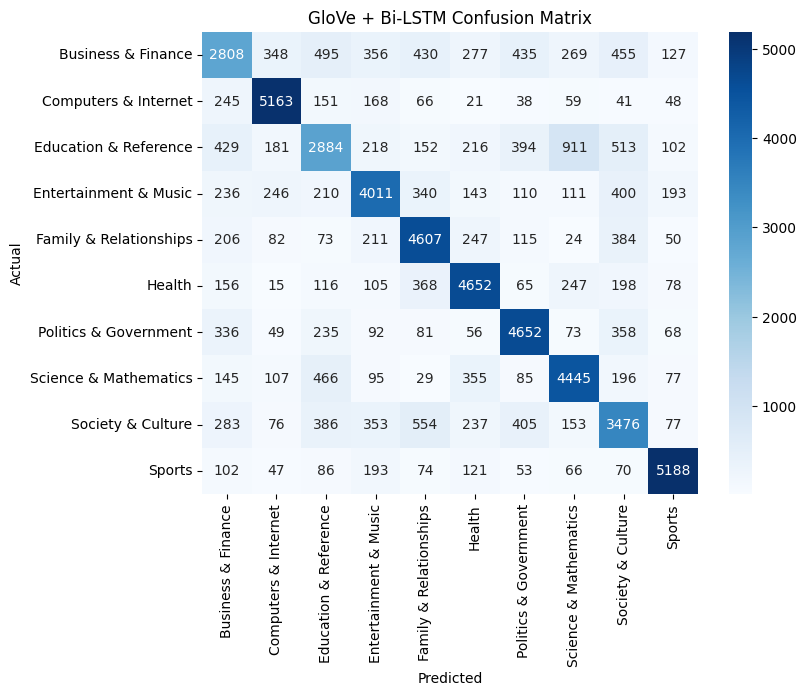

array([[2808,  348,  495,  356,  430,  277,  435,  269,  455,  127],
       [ 245, 5163,  151,  168,   66,   21,   38,   59,   41,   48],
       [ 429,  181, 2884,  218,  152,  216,  394,  911,  513,  102],
       [ 236,  246,  210, 4011,  340,  143,  110,  111,  400,  193],
       [ 206,   82,   73,  211, 4607,  247,  115,   24,  384,   50],
       [ 156,   15,  116,  105,  368, 4652,   65,  247,  198,   78],
       [ 336,   49,  235,   92,   81,   56, 4652,   73,  358,   68],
       [ 145,  107,  466,   95,   29,  355,   85, 4445,  196,   77],
       [ 283,   76,  386,  353,  554,  237,  405,  153, 3476,   77],
       [ 102,   47,   86,  193,   74,  121,   53,   66,   70, 5188]])

In [ ]:
with tf.device('/GPU:0'):
    model_glove_bilstm = Sequential([
        Embedding(input_dim=num_words, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH, trainable=True),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_glove_bilstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model_glove_bilstm.summary()

    history_glove_bilstm = model_glove_bilstm.fit(
        X_train_pad, y_train_onehot,
        epochs=10, batch_size=64, validation_split=0.2, verbose=1
    )

    y_pred_glove_bilstm = model_glove_bilstm.predict(X_test_pad, verbose=0).argmax(axis=1)

print("=== GloVe + Bi-LSTM ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_glove_bilstm))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_glove_bilstm, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_glove_bilstm, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_glove_bilstm, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_glove_bilstm, labels=le.classes_, title="GloVe + Bi-LSTM Confusion Matrix")


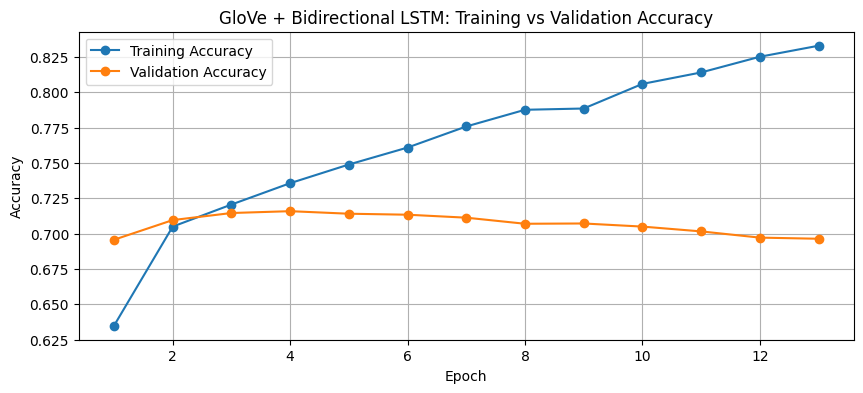

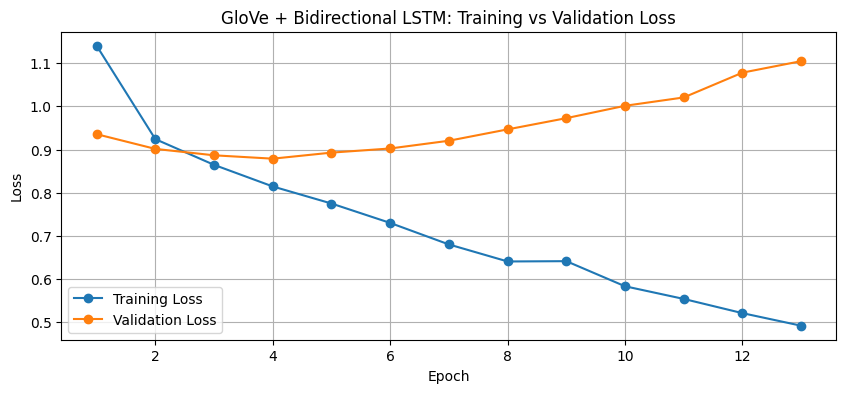

In [21]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 14))  # 13 epochs

# Accuracy
train_acc = [0.6349, 0.7050, 0.7206, 0.7357, 0.7489, 0.7609, 0.7758, 0.7876, 0.7885, 0.8059, 0.8140, 0.8251, 0.8329]
val_acc   = [0.6957, 0.7096, 0.7146, 0.7159, 0.7141, 0.7134, 0.7113, 0.7070, 0.7072, 0.7050, 0.7016, 0.6972, 0.6964]

# Loss
train_loss = [1.1402, 0.9240, 0.8645, 0.8145, 0.7750, 0.7301, 0.6803, 0.6409, 0.6416, 0.5835, 0.5542, 0.5213, 0.4922]
val_loss   = [0.9355, 0.9014, 0.8866, 0.8788, 0.8928, 0.9024, 0.9203, 0.9466, 0.9726, 1.0012, 1.0205, 1.0779, 1.1045]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('GloVe + Bidirectional LSTM: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('GloVe + Bidirectional LSTM: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


save

In [ ]:
# === GloVe + DNN ===
GloVe_DNN_accuracy = 0.6396106601776697
GloVe_DNN_f1_macro = 0.6340637385622243
GloVe_DNN_f1_weighted = 0.6340634381346733

# === GloVe + SimpleRNN (Optimized) ===
GloVe_SimpleRNN_accuracy = 0.2372706211770196
GloVe_SimpleRNN_f1_macro = 0.15223423310452797
GloVe_SimpleRNN_f1_weighted = 0.15223476582849274

# === GloVe + GRU ===
GloVe_GRU_accuracy = 0.7082284704745079
GloVe_GRU_f1_macro = 0.7031889490953563
GloVe_GRU_f1_weighted = 0.7031883063672809

# === GloVe + LSTM ===
GloVe_LSTM_accuracy = 0.7138452307538459
GloVe_LSTM_f1_macro = 0.7080823160623193
GloVe_LSTM_f1_weighted = 0.7080817218997708

# === GloVe + Bi-SimpleRNN ===
GloVe_BiSimpleRNN_accuracy = 0.6947282454707578
GloVe_BiSimpleRNN_f1_macro = 0.6897850879433283
GloVe_BiSimpleRNN_f1_weighted = 0.6897846155132802

# === GloVe + Bi-GRU ===
GloVe_BiGRU_accuracy = 0.6849280821347022
GloVe_BiGRU_f1_macro = 0.6828143781236007
GloVe_BiGRU_f1_weighted = 0.6828138655041668

# === GloVe + Bi-LSTM ===
GloVe_BiLSTM_accuracy = 0.6981116351939199
GloVe_BiLSTM_f1_macro = 0.6942957586978369
GloVe_BiLSTM_f1_weighted = 0.694295238421627


#Experiments with Skip-gram Representation

In [ ]:
# Must match the dimension of the loaded embeddings
embedding_dim = X_train_skipgram_avg.shape[1]
# Convert test classes to integer labels using the loaded LabelEncoder
y_test_int = le.transform(df_test['Class'])


In [ ]:
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
from tensorflow.keras.utils import to_categorical


In [ ]:
!pip install gensim


Skip-gram + Deep Neural Network

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,834 (85.29 KB)

 Trainable params: 21,834 (85.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6153 - loss: 1.2102 - val_accuracy: 0.6794 - val_loss: 0.9935
Epoch 2/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6740 - loss: 1.0254 - val_accuracy: 0.6809 - val_loss: 0.9803
Epoch 3/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6794 - loss: 1.0047 - val_accuracy: 0.6837 - val_loss: 0.9696
Epoch 4/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6858 - loss: 0.9840 - val_accuracy: 0.6851 - val_loss: 0.9653
Epoch 5/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6888 - loss: 0.9755 - val_accuracy: 0.6865 - val_loss: 0.9598
Epoch 6/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6907 - loss: 0.9662 - val_accuracy: 0.6894 - val_loss: 0.9586
Epoch 7/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6911 - loss: 0.9651 - val_accuracy: 0.6893 - val_loss: 0.9557
Epoch 8/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6927 - loss: 0

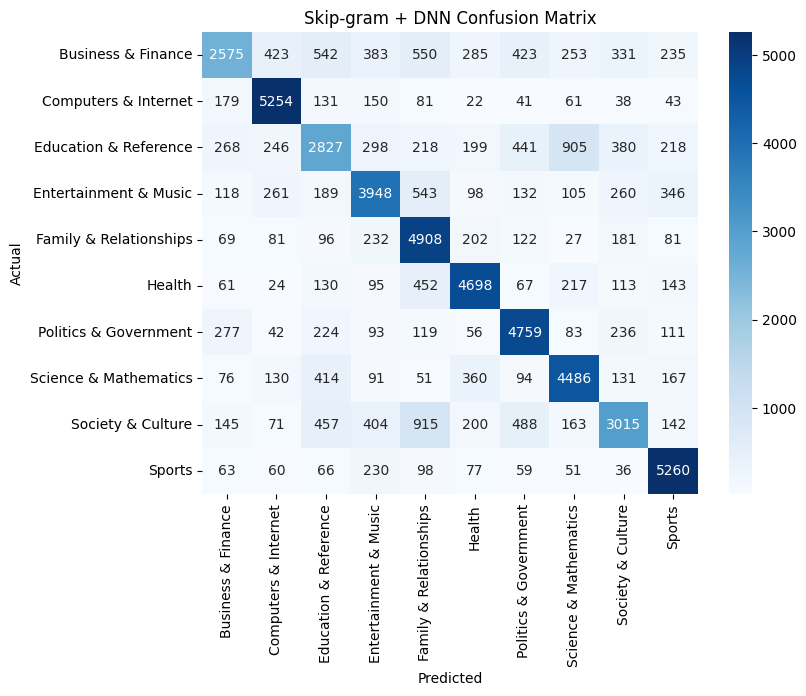

array([[2575,  423,  542,  383,  550,  285,  423,  253,  331,  235],
       [ 179, 5254,  131,  150,   81,   22,   41,   61,   38,   43],
       [ 268,  246, 2827,  298,  218,  199,  441,  905,  380,  218],
       [ 118,  261,  189, 3948,  543,   98,  132,  105,  260,  346],
       [  69,   81,   96,  232, 4908,  202,  122,   27,  181,   81],
       [  61,   24,  130,   95,  452, 4698,   67,  217,  113,  143],
       [ 277,   42,  224,   93,  119,   56, 4759,   83,  236,  111],
       [  76,  130,  414,   91,   51,  360,   94, 4486,  131,  167],
       [ 145,   71,  457,  404,  915,  200,  488,  163, 3015,  142],
       [  63,   60,   66,  230,   98,   77,   59,   51,   36, 5260]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, classification_report

with tf.device('/GPU:0'):
    model_skip_dnn = Sequential([
        Dense(128, activation="relu", input_shape=(embedding_dim,)),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_skip_dnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model_skip_dnn.summary()

    history_skip_dnn = model_skip_dnn.fit(
        X_train_skipgram_avg, y_train_onehot,
        epochs=20, batch_size=32, validation_split=0.2, verbose=1
    )

    y_pred_skip_dnn = model_skip_dnn.predict(X_test_skipgram_avg, verbose=0).argmax(axis=1)

print("=== Skip-gram + DNN ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_skip_dnn))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_skip_dnn, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_skip_dnn, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_skip_dnn, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_skip_dnn, labels=le.classes_, title="Skip-gram + DNN Confusion Matrix")


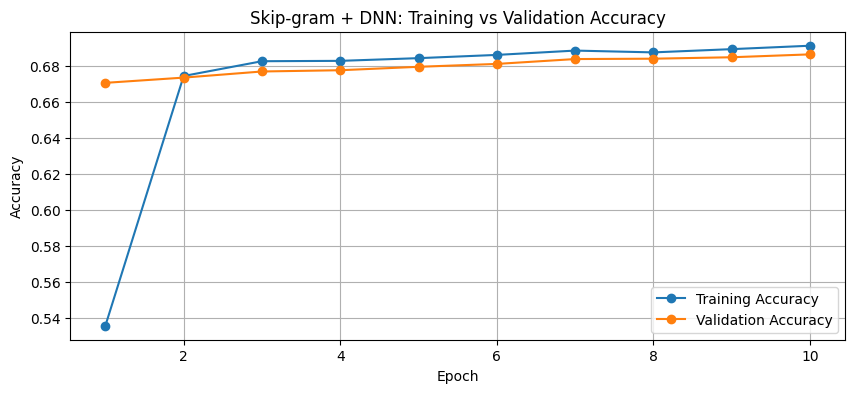

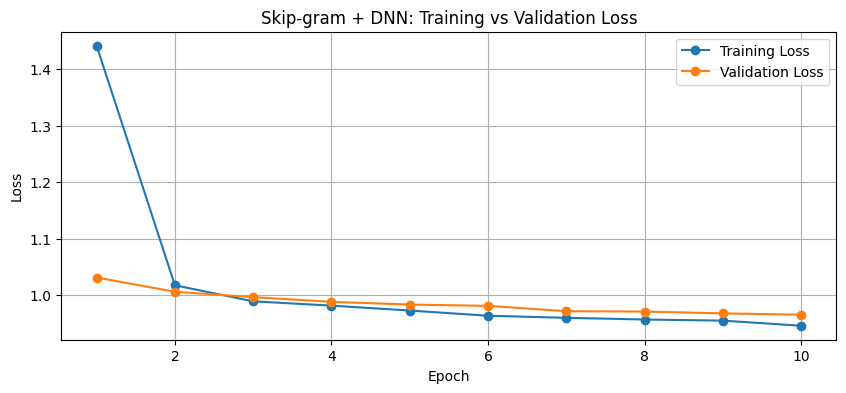

In [7]:
import matplotlib.pyplot as plt

# Example: replace these lists with your training history if not available
# You can copy from model.fit output if saved
train_acc = [0.5356, 0.6742, 0.6824, 0.6826, 0.6841, 0.6859, 0.6883, 0.6873, 0.6891, 0.6910]
val_acc   = [0.6704, 0.6733, 0.6767, 0.6774, 0.6793, 0.6809, 0.6836, 0.6838, 0.6846, 0.6862]

train_loss = [1.4416, 1.0171, 0.9887, 0.9811, 0.9724, 0.9632, 0.9595, 0.9565, 0.9545, 0.9455]
val_loss   = [1.0309, 1.0057, 0.9961, 0.9878, 0.9830, 0.9807, 0.9712, 0.9706, 0.9674, 0.9650]

epochs = list(range(1, len(train_acc)+1))

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('Skip-gram + DNN: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('Skip-gram + DNN: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Skip-gram + SimpleRNN

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5737 - loss: 1.3513 - val_accuracy: 0.6710 - val_loss: 1.0179
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6757 - loss: 1.0042 - val_accuracy: 0.6759 - val_loss: 1.0018
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6829 - loss: 0.9781 - val_accuracy: 0.6801 - val_loss: 0.9867
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6854 - loss: 0.9687 - val_accuracy: 0.6796 - val_loss: 0.9814
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6856 - loss: 0.9647 - val_accuracy: 0.6790 - val_loss: 0.9862
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6878 - loss: 0.9597 - val_accuracy: 0.6838 - val_loss: 0.9699
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6880 - loss: 0.9565 - val_accuracy: 0.6833 - val_loss: 0.9717
Epoch 8/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6911 - loss: 0.9469

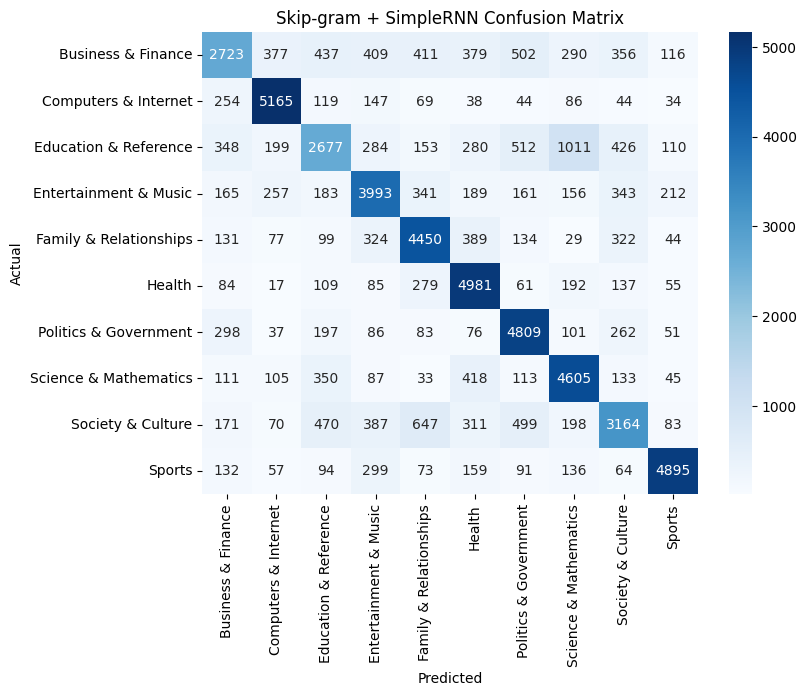

array([[2723,  377,  437,  409,  411,  379,  502,  290,  356,  116],
       [ 254, 5165,  119,  147,   69,   38,   44,   86,   44,   34],
       [ 348,  199, 2677,  284,  153,  280,  512, 1011,  426,  110],
       [ 165,  257,  183, 3993,  341,  189,  161,  156,  343,  212],
       [ 131,   77,   99,  324, 4450,  389,  134,   29,  322,   44],
       [  84,   17,  109,   85,  279, 4981,   61,  192,  137,   55],
       [ 298,   37,  197,   86,   83,   76, 4809,  101,  262,   51],
       [ 111,  105,  350,   87,   33,  418,  113, 4605,  133,   45],
       [ 171,   70,  470,  387,  647,  311,  499,  198, 3164,   83],
       [ 132,   57,   94,  299,   73,  159,   91,  136,   64, 4895]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, classification_report

with tf.device('/GPU:0'):
    model_skip_rnn = Sequential([
        Dense(64, activation="relu", input_shape=(embedding_dim,)),
        Dense(32, activation="relu"),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_skip_rnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_skip_rnn = model_skip_rnn.fit(
        X_train_skipgram_avg, y_train_onehot,
        epochs=10, batch_size=128, validation_split=0.2, verbose=1
    )

    y_pred_skip_rnn = model_skip_rnn.predict(X_test_skipgram_avg, verbose=0).argmax(axis=1)

print("=== Skip-gram + SimpleRNN ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_skip_rnn))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_skip_rnn, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_skip_rnn, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_skip_rnn, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_skip_rnn, labels=le.classes_, title="Skip-gram + SimpleRNN Confusion Matrix")


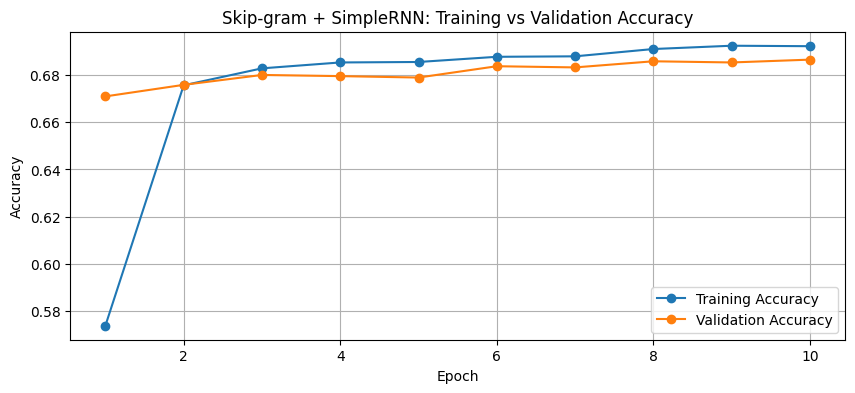

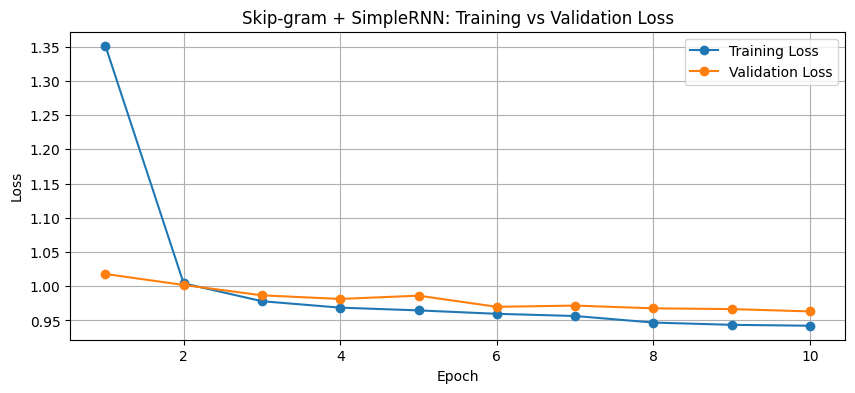

In [8]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Accuracy
train_acc = [0.5737, 0.6757, 0.6829, 0.6854, 0.6856, 0.6878, 0.6880, 0.6911, 0.6925, 0.6923]
val_acc   = [0.6710, 0.6759, 0.6801, 0.6796, 0.6790, 0.6838, 0.6833, 0.6859, 0.6854, 0.6866]

# Loss
train_loss = [1.3513, 1.0042, 0.9781, 0.9687, 0.9647, 0.9597, 0.9565, 0.9469, 0.9436, 0.9423]
val_loss   = [1.0179, 1.0018, 0.9867, 0.9814, 0.9862, 0.9699, 0.9717, 0.9677, 0.9666, 0.9632]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('Skip-gram + SimpleRNN: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('Skip-gram + SimpleRNN: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Skip-gram + GRU

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5796 - loss: 1.3312 - val_accuracy: 0.6705 - val_loss: 1.0176
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6759 - loss: 1.0040 - val_accuracy: 0.6747 - val_loss: 0.9972
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6804 - loss: 0.9846 - val_accuracy: 0.6792 - val_loss: 0.9857
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6840 - loss: 0.9719 - val_accuracy: 0.6796 - val_loss: 0.9818
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6867 - loss: 0.9643 - val_accuracy: 0.6825 - val_loss: 0.9744
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6864 - loss: 0.9631 - val_accuracy: 0.6790 - val_loss: 0.9776
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6881 - loss: 0.9544 - val_accuracy: 0.6839 - val_loss: 0.9685
Epoch 8/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6890 - loss: 0.9515 - 

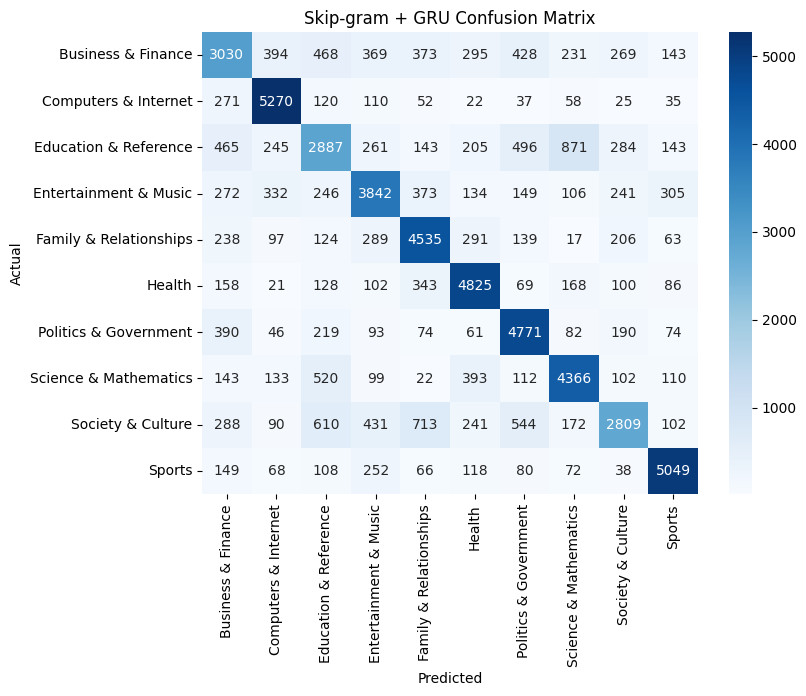

array([[3030,  394,  468,  369,  373,  295,  428,  231,  269,  143],
       [ 271, 5270,  120,  110,   52,   22,   37,   58,   25,   35],
       [ 465,  245, 2887,  261,  143,  205,  496,  871,  284,  143],
       [ 272,  332,  246, 3842,  373,  134,  149,  106,  241,  305],
       [ 238,   97,  124,  289, 4535,  291,  139,   17,  206,   63],
       [ 158,   21,  128,  102,  343, 4825,   69,  168,  100,   86],
       [ 390,   46,  219,   93,   74,   61, 4771,   82,  190,   74],
       [ 143,  133,  520,   99,   22,  393,  112, 4366,  102,  110],
       [ 288,   90,  610,  431,  713,  241,  544,  172, 2809,  102],
       [ 149,   68,  108,  252,   66,  118,   80,   72,   38, 5049]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, classification_report

with tf.device('/GPU:0'):
    model_skip_gru = Sequential([
        Dense(64, activation="relu", input_shape=(embedding_dim,)),
        Dense(32, activation="relu"),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_skip_gru.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_skip_gru = model_skip_gru.fit(
        X_train_skipgram_avg, y_train_onehot,
        epochs=10, batch_size=128, validation_split=0.2, verbose=1
    )

    y_pred_skip_gru = model_skip_gru.predict(X_test_skipgram_avg, verbose=0).argmax(axis=1)

print("=== Skip-gram + GRU  ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_skip_gru))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_skip_gru, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_skip_gru, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_skip_gru, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_skip_gru, labels=le.classes_, title="Skip-gram + GRU Confusion Matrix")


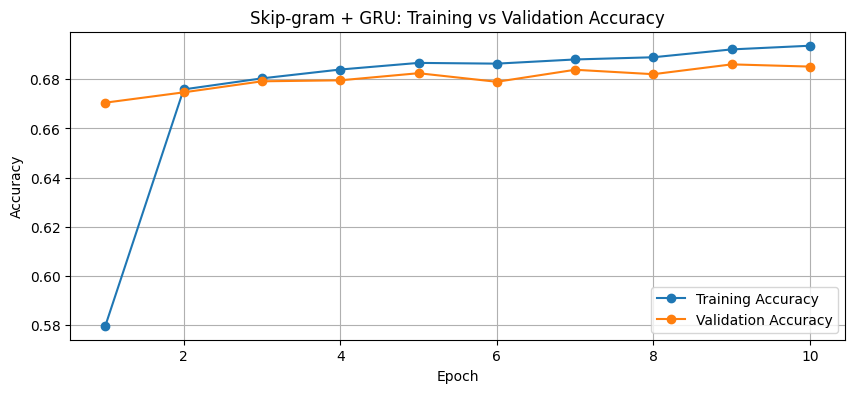

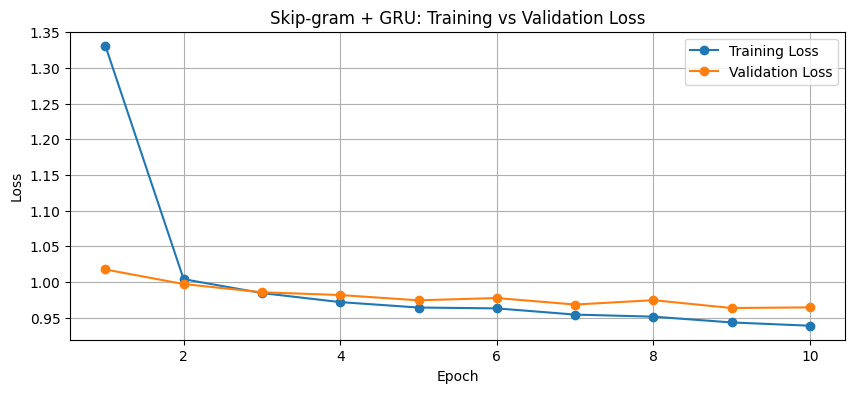

In [9]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Accuracy
train_acc = [0.5796, 0.6759, 0.6804, 0.6840, 0.6867, 0.6864, 0.6881, 0.6890, 0.6922, 0.6937]
val_acc   = [0.6705, 0.6747, 0.6792, 0.6796, 0.6825, 0.6790, 0.6839, 0.6821, 0.6861, 0.6852]

# Loss
train_loss = [1.3312, 1.0040, 0.9846, 0.9719, 0.9643, 0.9631, 0.9544, 0.9515, 0.9434, 0.9388]
val_loss   = [1.0176, 0.9972, 0.9857, 0.9818, 0.9744, 0.9776, 0.9685, 0.9746, 0.9636, 0.9645]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('Skip-gram + GRU: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('Skip-gram + GRU: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Skip-gram + LSTM

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5918 - loss: 1.3036 - val_accuracy: 0.6733 - val_loss: 1.0186
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6779 - loss: 1.0004 - val_accuracy: 0.6784 - val_loss: 0.9925
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6814 - loss: 0.9809 - val_accuracy: 0.6788 - val_loss: 0.9891
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6854 - loss: 0.9710 - val_accuracy: 0.6822 - val_loss: 0.9789
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6862 - loss: 0.9632 - val_accuracy: 0.6848 - val_loss: 0.9690
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6882 - loss: 0.9564 - val_accuracy: 0.6844 - val_loss: 0.9685
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6904 - loss: 0.9515 - val_accuracy: 0.6851 - val_loss: 0.9690
Epoch 8/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6923 - loss: 0.9442 

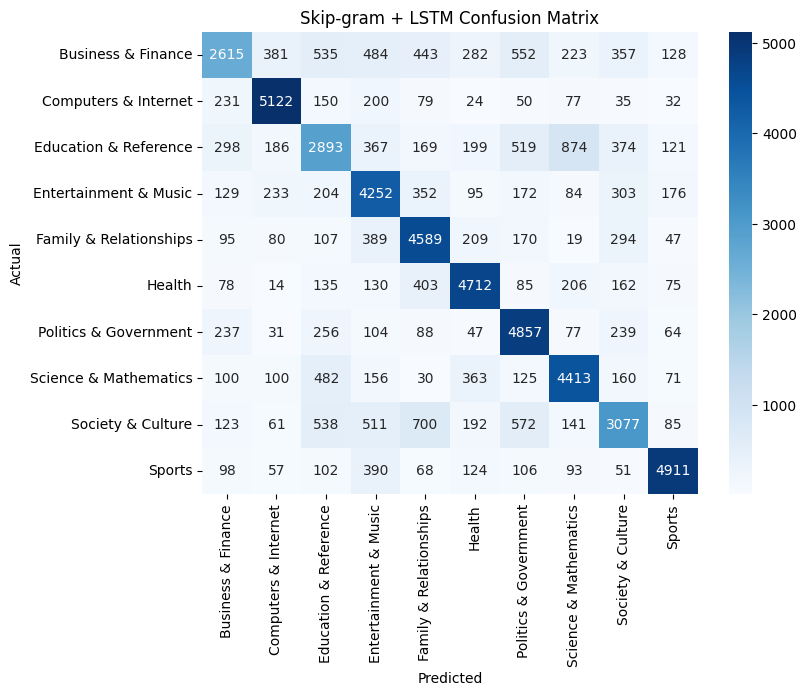

array([[2615,  381,  535,  484,  443,  282,  552,  223,  357,  128],
       [ 231, 5122,  150,  200,   79,   24,   50,   77,   35,   32],
       [ 298,  186, 2893,  367,  169,  199,  519,  874,  374,  121],
       [ 129,  233,  204, 4252,  352,   95,  172,   84,  303,  176],
       [  95,   80,  107,  389, 4589,  209,  170,   19,  294,   47],
       [  78,   14,  135,  130,  403, 4712,   85,  206,  162,   75],
       [ 237,   31,  256,  104,   88,   47, 4857,   77,  239,   64],
       [ 100,  100,  482,  156,   30,  363,  125, 4413,  160,   71],
       [ 123,   61,  538,  511,  700,  192,  572,  141, 3077,   85],
       [  98,   57,  102,  390,   68,  124,  106,   93,   51, 4911]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, classification_report

with tf.device('/GPU:0'):
    model_skip_lstm = Sequential([
        Dense(64, activation="relu", input_shape=(embedding_dim,)),   # reduced from 128
        Dense(32, activation="relu"),                                  # reduced from 64
        Dense(len(le.classes_), activation="softmax")
    ])

    model_skip_lstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_skip_lstm = model_skip_lstm.fit(
        X_train_skipgram_avg, y_train_onehot,
        epochs=10, batch_size=128, validation_split=0.2, verbose=1
    )

    y_pred_skip_lstm = model_skip_lstm.predict(X_test_skipgram_avg, verbose=0).argmax(axis=1)

print("=== Skip-gram + LSTM  ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_skip_lstm))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_skip_lstm, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_skip_lstm, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_skip_lstm, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_skip_lstm, labels=le.classes_, title="Skip-gram + LSTM Confusion Matrix")


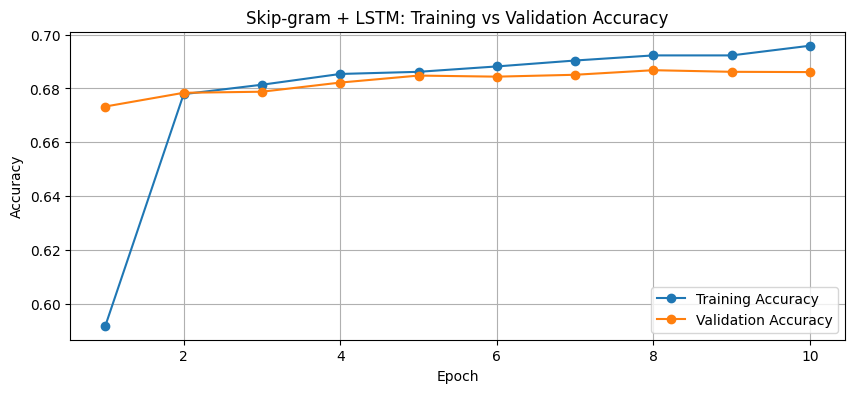

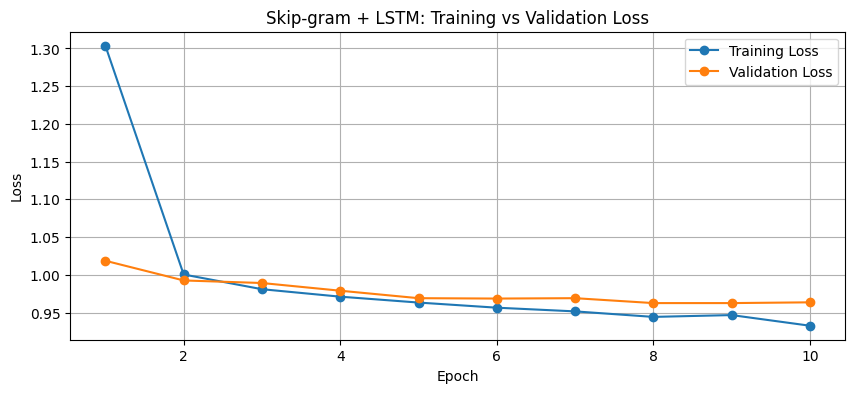

In [10]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Accuracy
train_acc = [0.5918, 0.6779, 0.6814, 0.6854, 0.6862, 0.6882, 0.6904, 0.6923, 0.6923, 0.6959]
val_acc   = [0.6733, 0.6784, 0.6788, 0.6822, 0.6848, 0.6844, 0.6851, 0.6868, 0.6862, 0.6861]

# Loss
train_loss = [1.3036, 1.0004, 0.9809, 0.9710, 0.9632, 0.9564, 0.9515, 0.9442, 0.9466, 0.9325]
val_loss   = [1.0186, 0.9925, 0.9891, 0.9789, 0.9690, 0.9685, 0.9690, 0.9625, 0.9625, 0.9635]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('Skip-gram + LSTM: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('Skip-gram + LSTM: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Skip-gram + Bidirectional SimpleRNN

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5949 - loss: 1.2932 - val_accuracy: 0.6709 - val_loss: 1.0176
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6759 - loss: 1.0009 - val_accuracy: 0.6759 - val_loss: 0.9962
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6813 - loss: 0.9831 - val_accuracy: 0.6806 - val_loss: 0.9845
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6838 - loss: 0.9730 - val_accuracy: 0.6818 - val_loss: 0.9795
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6837 - loss: 0.9681 - val_accuracy: 0.6831 - val_loss: 0.9732
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6898 - loss: 0.9521 - val_accuracy: 0.6828 - val_loss: 0.9729
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6892 - loss: 0.9538 - val_accuracy: 0.6841 - val_loss: 0.9701
Epoch 8/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6917 - loss: 0.9442 -

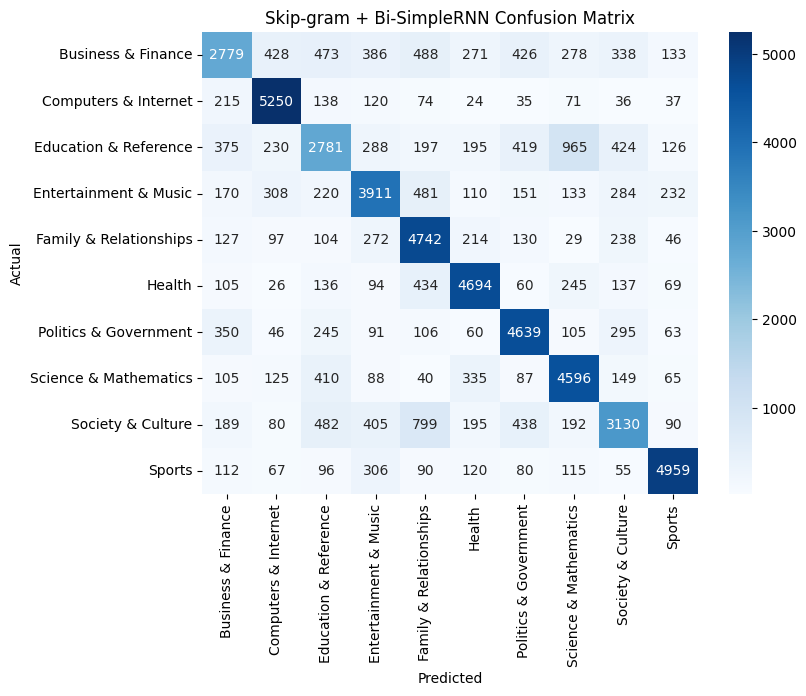

array([[2779,  428,  473,  386,  488,  271,  426,  278,  338,  133],
       [ 215, 5250,  138,  120,   74,   24,   35,   71,   36,   37],
       [ 375,  230, 2781,  288,  197,  195,  419,  965,  424,  126],
       [ 170,  308,  220, 3911,  481,  110,  151,  133,  284,  232],
       [ 127,   97,  104,  272, 4742,  214,  130,   29,  238,   46],
       [ 105,   26,  136,   94,  434, 4694,   60,  245,  137,   69],
       [ 350,   46,  245,   91,  106,   60, 4639,  105,  295,   63],
       [ 105,  125,  410,   88,   40,  335,   87, 4596,  149,   65],
       [ 189,   80,  482,  405,  799,  195,  438,  192, 3130,   90],
       [ 112,   67,   96,  306,   90,  120,   80,  115,   55, 4959]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, classification_report

with tf.device('/GPU:0'):
    model_skip_bi_rnn = Sequential([
        Dense(64, activation="relu", input_shape=(embedding_dim,)),   # reduced from 128
        Dense(32, activation="relu"),                                  # reduced from 64
        Dense(len(le.classes_), activation="softmax")
    ])

    model_skip_bi_rnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_skip_bi_rnn = model_skip_bi_rnn.fit(
        X_train_skipgram_avg, y_train_onehot,
        epochs=10, batch_size=128, validation_split=0.2, verbose=1
    )

    y_pred_skip_bi_rnn = model_skip_bi_rnn.predict(X_test_skipgram_avg, verbose=0).argmax(axis=1)

print("=== Skip-gram + Bidirectional SimpleRNN  ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_skip_bi_rnn))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_skip_bi_rnn, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_skip_bi_rnn, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_skip_bi_rnn, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_skip_bi_rnn, labels=le.classes_, title="Skip-gram + Bi-SimpleRNN Confusion Matrix")


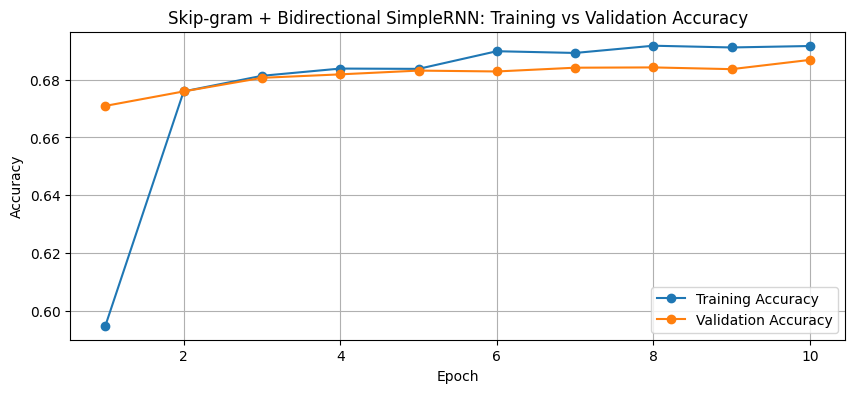

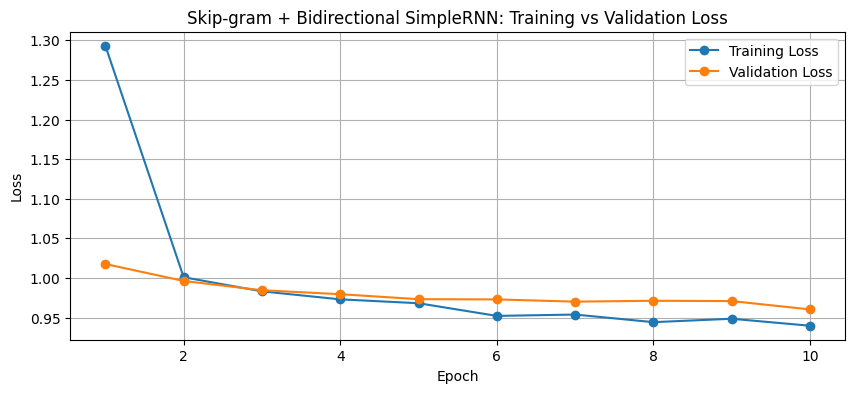

In [11]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Accuracy
train_acc = [0.5949, 0.6759, 0.6813, 0.6838, 0.6837, 0.6898, 0.6892, 0.6917, 0.6911, 0.6916]
val_acc   = [0.6709, 0.6759, 0.6806, 0.6818, 0.6831, 0.6828, 0.6841, 0.6842, 0.6836, 0.6868]

# Loss
train_loss = [1.2932, 1.0009, 0.9831, 0.9730, 0.9681, 0.9521, 0.9538, 0.9442, 0.9485, 0.9397]
val_loss   = [1.0176, 0.9962, 0.9845, 0.9795, 0.9732, 0.9729, 0.9701, 0.9712, 0.9708, 0.9603]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('Skip-gram + Bidirectional SimpleRNN: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('Skip-gram + Bidirectional SimpleRNN: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Skip-gram + Bidirectional GRU

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5954 - loss: 1.2562 - val_accuracy: 0.6743 - val_loss: 1.0115
Epoch 2/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6741 - loss: 1.0286 - val_accuracy: 0.6811 - val_loss: 0.9838
Epoch 3/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6782 - loss: 1.0092 - val_accuracy: 0.6825 - val_loss: 0.9775
Epoch 4/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.6824 - loss: 0.9921 - val_accuracy: 0.6837 - val_loss: 0.9661
Epoch 5/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6869 - loss: 0.9781 - val_accuracy: 0.6873 - val_loss: 0.9619
Epoch 6/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6877 - loss: 0.9753 - val_accuracy: 0.6867 - val_loss: 0.9634
Epoch 7/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6908 - loss: 0.9623 - val_accuracy: 0.6893 - val_loss: 0.9564
Epoch 8/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6922 - loss: 0

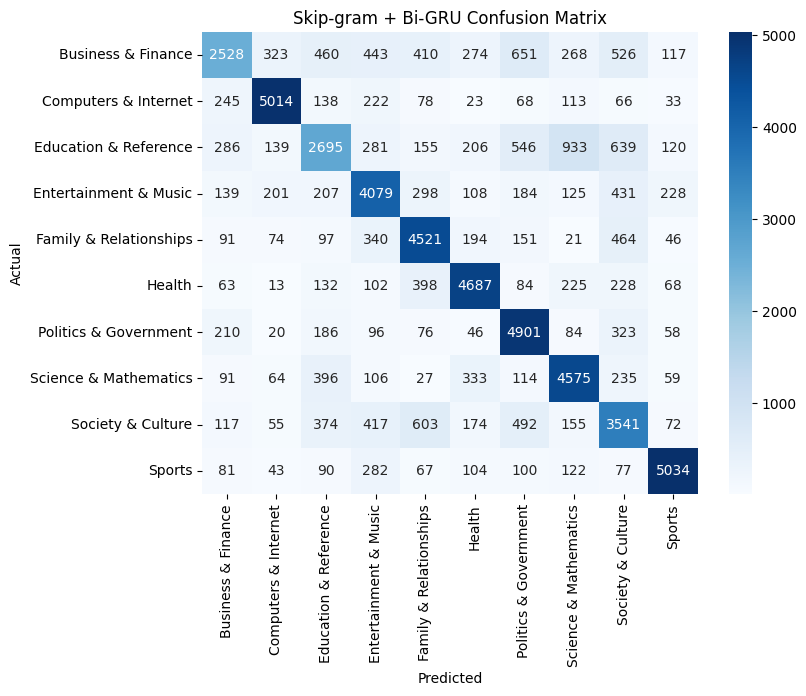

array([[2528,  323,  460,  443,  410,  274,  651,  268,  526,  117],
       [ 245, 5014,  138,  222,   78,   23,   68,  113,   66,   33],
       [ 286,  139, 2695,  281,  155,  206,  546,  933,  639,  120],
       [ 139,  201,  207, 4079,  298,  108,  184,  125,  431,  228],
       [  91,   74,   97,  340, 4521,  194,  151,   21,  464,   46],
       [  63,   13,  132,  102,  398, 4687,   84,  225,  228,   68],
       [ 210,   20,  186,   96,   76,   46, 4901,   84,  323,   58],
       [  91,   64,  396,  106,   27,  333,  114, 4575,  235,   59],
       [ 117,   55,  374,  417,  603,  174,  492,  155, 3541,   72],
       [  81,   43,   90,  282,   67,  104,  100,  122,   77, 5034]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, classification_report

with tf.device('/GPU:0'):
    model_skip_bi_gru = Sequential([
        Dense(128, activation="relu", input_shape=(embedding_dim,)),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_skip_bi_gru.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_skip_bi_gru = model_skip_bi_gru.fit(
        X_train_skipgram_avg, y_train_onehot,
        epochs=10, batch_size=64, validation_split=0.2, verbose=1
    )

    y_pred_skip_bi_gru = model_skip_bi_gru.predict(X_test_skipgram_avg, verbose=0).argmax(axis=1)

# Evaluation
print("=== Skip-gram + Bidirectional GRU ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_skip_bi_gru))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_skip_bi_gru, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_skip_bi_gru, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_skip_bi_gru, target_names=le.classes_))

# Confusion matrix plot
plot_confusion_matrix(y_test_int, y_pred_skip_bi_gru, labels=le.classes_, title="Skip-gram + Bi-GRU Confusion Matrix")


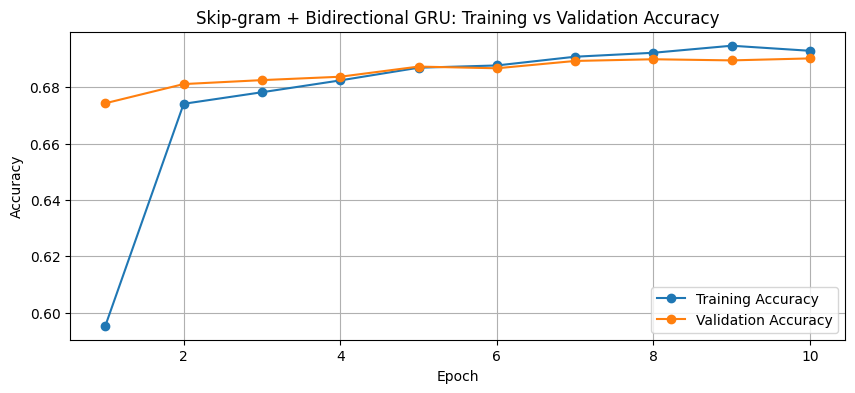

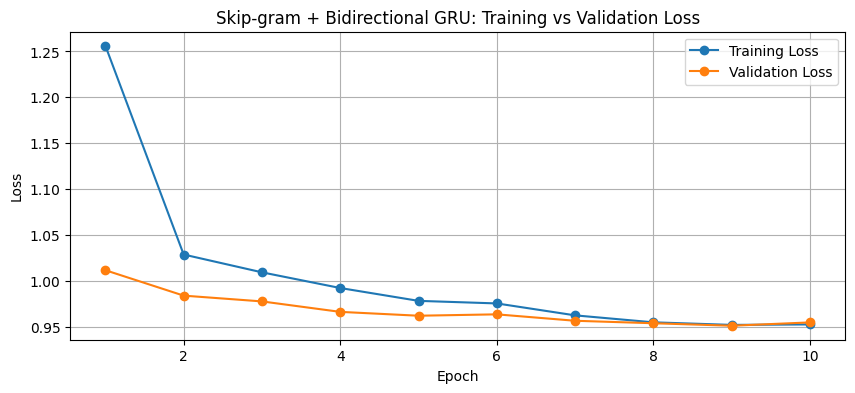

In [12]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Accuracy
train_acc = [0.5954, 0.6741, 0.6782, 0.6824, 0.6869, 0.6877, 0.6908, 0.6922, 0.6947, 0.6929]
val_acc   = [0.6743, 0.6811, 0.6825, 0.6837, 0.6873, 0.6867, 0.6893, 0.6899, 0.6895, 0.6902]

# Loss
train_loss = [1.2562, 1.0286, 1.0092, 0.9921, 0.9781, 0.9753, 0.9623, 0.9547, 0.9519, 0.9524]
val_loss   = [1.0115, 0.9838, 0.9775, 0.9661, 0.9619, 0.9634, 0.9564, 0.9537, 0.9510, 0.9546]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('Skip-gram + Bidirectional GRU: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('Skip-gram + Bidirectional GRU: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Skip-gram + Bidirectional LSTM

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5356 - loss: 1.4416 - val_accuracy: 0.6704 - val_loss: 1.0309
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6742 - loss: 1.0171 - val_accuracy: 0.6733 - val_loss: 1.0057
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6824 - loss: 0.9887 - val_accuracy: 0.6767 - val_loss: 0.9961
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6826 - loss: 0.9811 - val_accuracy: 0.6774 - val_loss: 0.9878
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6841 - loss: 0.9724 - val_accuracy: 0.6793 - val_loss: 0.9830
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6859 - loss: 0.9632 - val_accuracy: 0.6809 - val_loss: 0.9807
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6883 - loss: 0.9595 - val_accuracy: 0.6836 - val_loss: 0.9712
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6873 - loss: 0.9565 - val_accuracy: 0.

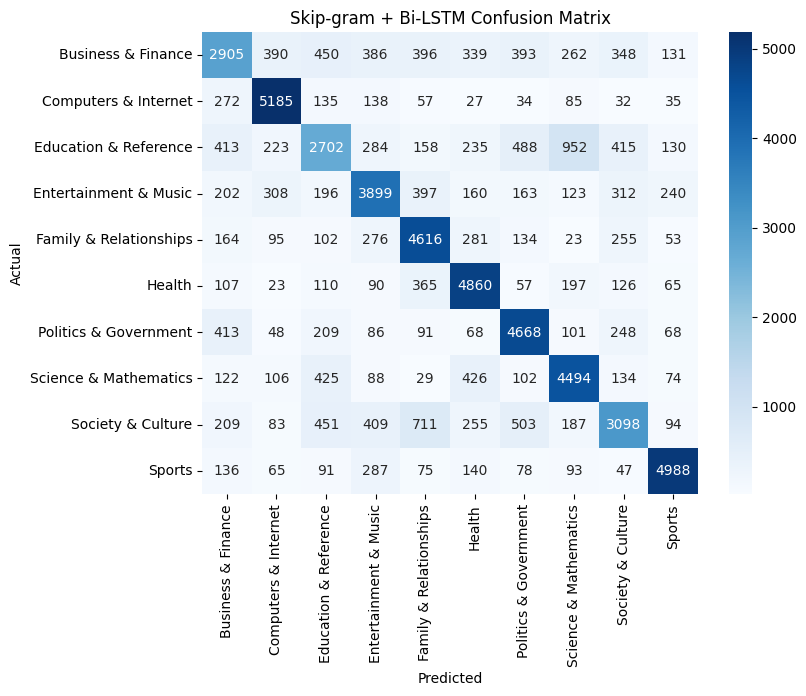

array([[2905,  390,  450,  386,  396,  339,  393,  262,  348,  131],
       [ 272, 5185,  135,  138,   57,   27,   34,   85,   32,   35],
       [ 413,  223, 2702,  284,  158,  235,  488,  952,  415,  130],
       [ 202,  308,  196, 3899,  397,  160,  163,  123,  312,  240],
       [ 164,   95,  102,  276, 4616,  281,  134,   23,  255,   53],
       [ 107,   23,  110,   90,  365, 4860,   57,  197,  126,   65],
       [ 413,   48,  209,   86,   91,   68, 4668,  101,  248,   68],
       [ 122,  106,  425,   88,   29,  426,  102, 4494,  134,   74],
       [ 209,   83,  451,  409,  711,  255,  503,  187, 3098,   94],
       [ 136,   65,   91,  287,   75,  140,   78,   93,   47, 4988]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, classification_report

with tf.device('/GPU:0'):
    model_skip_bi_lstm = Sequential([
        Dense(64, activation="relu", input_shape=(embedding_dim,)),
        Dense(32, activation="relu"),
        Dense(len(le.classes_), activation="softmax")
    ])

    model_skip_bi_lstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_skip_bi_lstm = model_skip_bi_lstm.fit(
        X_train_skipgram_avg, y_train_onehot,
        epochs=10, batch_size=256, validation_split=0.2, verbose=1
    )

    y_pred_skip_bi_lstm = model_skip_bi_lstm.predict(X_test_skipgram_avg, verbose=0).argmax(axis=1)

print("=== Skip-gram + Bidirectional LSTM  ===")
print("Accuracy:", accuracy_score(y_test_int, y_pred_skip_bi_lstm))
print("F1-score (Macro):", f1_score(y_test_int, y_pred_skip_bi_lstm, average='macro'))
print("F1-score (Weighted):", f1_score(y_test_int, y_pred_skip_bi_lstm, average='weighted'))
print("Classification Report:\n", classification_report(y_test_int, y_pred_skip_bi_lstm, target_names=le.classes_))

plot_confusion_matrix(y_test_int, y_pred_skip_bi_lstm, labels=le.classes_, title="Skip-gram + Bi-LSTM Confusion Matrix")


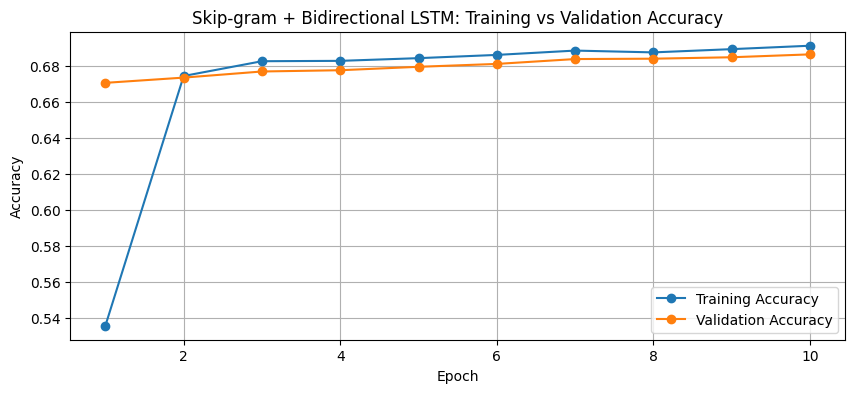

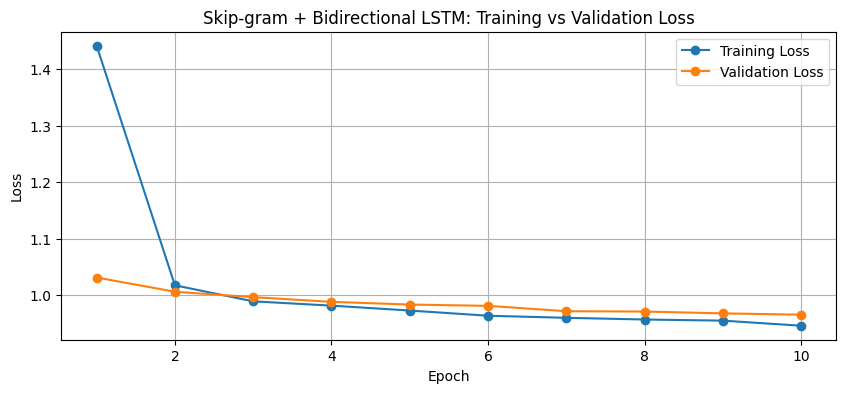

In [13]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Accuracy
train_acc = [0.5356, 0.6742, 0.6824, 0.6826, 0.6841, 0.6859, 0.6883, 0.6873, 0.6891, 0.6910]
val_acc   = [0.6704, 0.6733, 0.6767, 0.6774, 0.6793, 0.6809, 0.6836, 0.6838, 0.6846, 0.6862]

# Loss
train_loss = [1.4416, 1.0171, 0.9887, 0.9811, 0.9724, 0.9632, 0.9595, 0.9565, 0.9545, 0.9455]
val_loss   = [1.0309, 1.0057, 0.9961, 0.9878, 0.9830, 0.9807, 0.9712, 0.9706, 0.9674, 0.9650]

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('Skip-gram + Bidirectional LSTM: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('Skip-gram + Bidirectional LSTM: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


save

In [ ]:
# === Skip-gram + DNN ===
Skipgram_DNN_accuracy = 0.6955115918598643
Skipgram_DNN_f1_macro = 0.6873900169157191
Skipgram_DNN_f1_weighted = 0.6873897323462376

# === Skip-gram + SimpleRNN ===
Skipgram_SimpleRNN_accuracy = 0.6910448507475124
Skipgram_SimpleRNN_f1_macro = 0.6847108587055919
Skipgram_SimpleRNN_f1_weighted = 0.6847104398449213

# === Skip-gram + GRU ===
Skipgram_GRU_accuracy = 0.6897448290804846
Skipgram_GRU_f1_macro = 0.684095759698493
Skipgram_GRU_f1_weighted = 0.6840952518346198

# === Skip-gram + LSTM ===
Skipgram_LSTM_accuracy = 0.690694844914082
Skipgram_LSTM_f1_macro = 0.6854428081308914
Skipgram_LSTM_f1_weighted = 0.6854423926454849

# === Skip-gram + Bidirectional SimpleRNN ===
Skipgram_BiSimpleRNN_accuracy = 0.6913615226920449
Skipgram_BiSimpleRNN_f1_macro = 0.685699576291509
Skipgram_BiSimpleRNN_f1_weighted = 0.6856992524438577

# === Skip-gram + Bidirectional LSTM ===
Skipgram_BiLSTM_accuracy = 0.6902615043584059
Skipgram_BiLSTM_f1_macro = 0.6844968701824194
Skipgram_BiLSTM_f1_weighted = 0.6844963452559365

# === Skip-gram + Bidirectional GRU ===
Skipgram_BiGRU_accuracy = 0.6929282154702578
Skipgram_BiGRU_f1_macro = 0.6878290586824971
Skipgram_BiGRU_f1_weighted = 0.6878285924733722


#Compare Models

Functions for plotting and tabular comparison

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_comparison_df(model_names, accuracies, f1_macros, f1_weighted, model_types):
    """
    Create a pandas DataFrame for all models.
    """
    df = pd.DataFrame({
        "Model": model_names,
        "Type": model_types,
        "Accuracy": accuracies,
        "F1-Macro": f1_macros,
        "F1-Weighted": f1_weighted
    })
    return df

def plot_bar(df, metric, title):
    """
    Plot bar chart for a given metric.
    """
    plt.figure(figsize=(12,6))
    sns.barplot(x=metric, y="Model", data=df.sort_values(metric, ascending=False), hue="Type", dodge=False)
    plt.title(title)
    plt.show()


Visual representations to compare all models

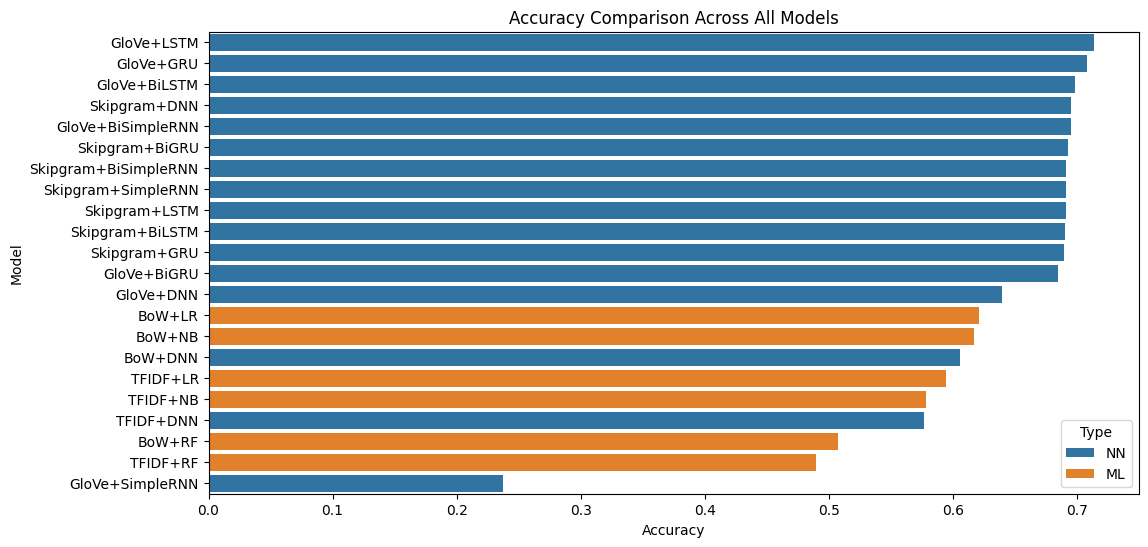

In [ ]:
# Accuracy
plt.figure(figsize=(12,6))
sns.barplot(x="Accuracy", y="Model", data=df_models.sort_values("Accuracy", ascending=False), hue="Type", dodge=False)
plt.title("Accuracy Comparison Across All Models")
plt.show()


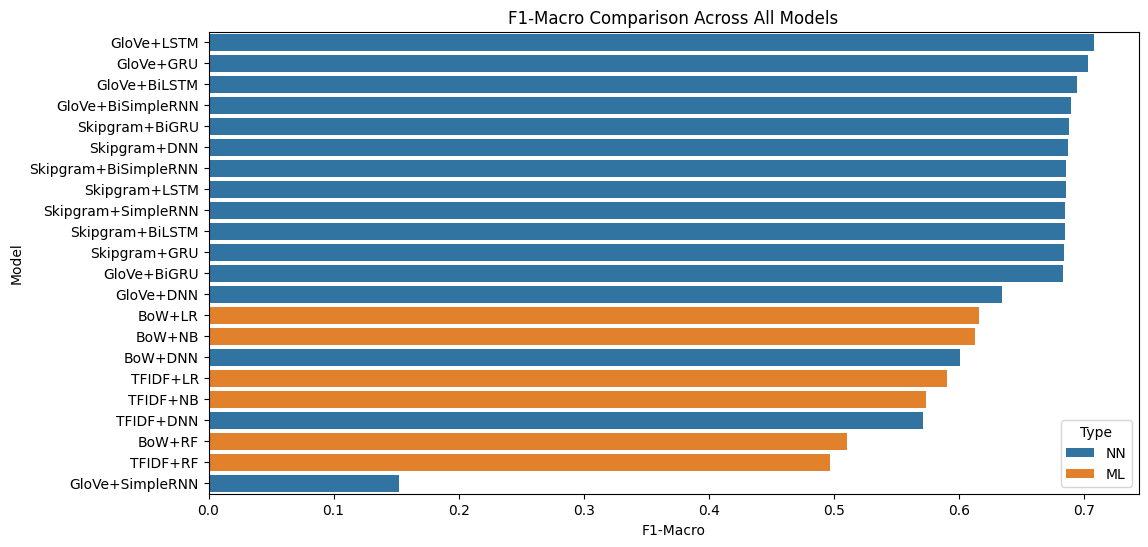

In [ ]:
#F1-Macro
plt.figure(figsize=(12,6))
sns.barplot(x="F1-Macro", y="Model", data=df_models.sort_values("F1-Macro", ascending=False), hue="Type", dodge=False)
plt.title("F1-Macro Comparison Across All Models")
plt.show()


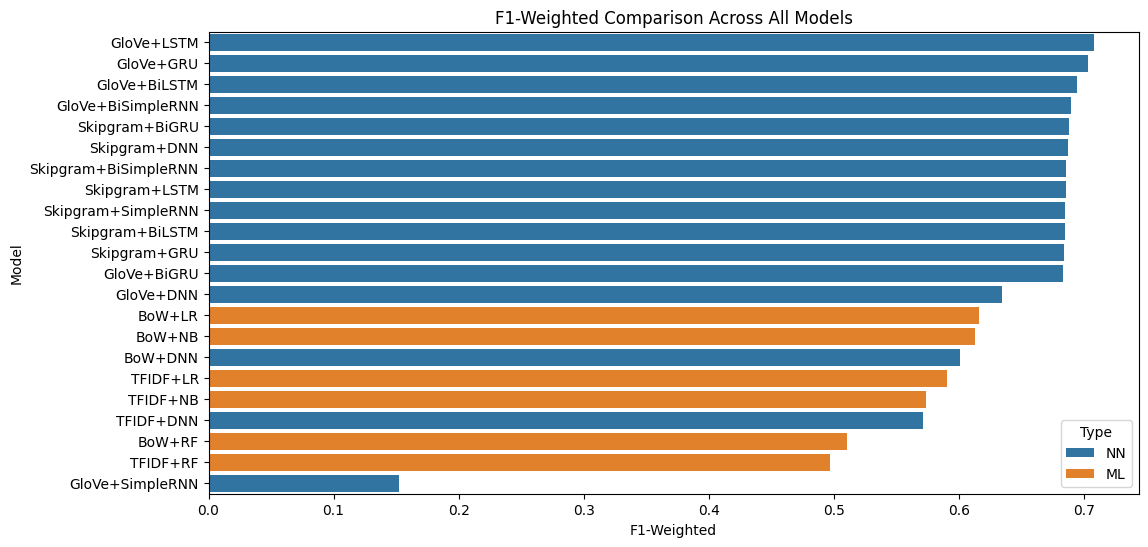

In [ ]:
#F1-Weighted
plt.figure(figsize=(12,6))
sns.barplot(x="F1-Weighted", y="Model", data=df_models.sort_values("F1-Weighted", ascending=False), hue="Type", dodge=False)
plt.title("F1-Weighted Comparison Across All Models")
plt.show()


Tabular representations to compare all models

In [ ]:
print("=== Tabular Comparison of All Models ===")
display(df_models.sort_values("Accuracy", ascending=False))


=== Tabular Comparison of All Models ===


Model Type  Accuracy  F1-Macro  F1-Weighted
10            GloVe+LSTM   NN  0.713845  0.708082     0.708082
9              GloVe+GRU   NN  0.708228  0.703189     0.703188
13          GloVe+BiLSTM   NN  0.698112  0.694296     0.694295
0           Skipgram+DNN   NN  0.695512  0.687390     0.687390
11     GloVe+BiSimpleRNN   NN  0.694728  0.689785     0.689785
6         Skipgram+BiGRU   NN  0.692928  0.687829     0.687829
4   Skipgram+BiSimpleRNN   NN  0.691362  0.685700     0.685699
1     Skipgram+SimpleRNN   NN  0.691045  0.684711     0.684710
3          Skipgram+LSTM   NN  0.690695  0.685443     0.685442
5        Skipgram+BiLSTM   NN  0.690262  0.684497     0.684496
2           Skipgram+GRU   NN  0.689745  0.684096     0.684095
12           GloVe+BiGRU   NN  0.684928  0.682814     0.682814
7              GloVe+DNN   NN  0.639611  0.634064     0.634063
19                BoW+LR   ML  0.620727  0.616276     0.616275
20                BoW+NB   ML  0.616544  0.612493     0.612492
21               BoW+DNN   NN  0.605743  0.600985     0.600984
15              TFIDF+LR   ML  0.594260  0.590364     0.590362
16              TFIDF+NB   ML  0.578393  0.573494     0.573493
17             TFIDF+DNN   NN  0.576776  0.571464     0.571463
18                BoW+RF   ML  0.507658  0.510366     0.510364
14              TFIDF+RF   ML  0.489275  0.496800     0.496798
8        GloVe+SimpleRNN   NN  0.237271  0.152234     0.152235

Best and Worst ML models (Visual + Tabular)

In [ ]:
df_ml = df_models[df_models['Type'] == "ML"]

best_ml = df_ml.loc[df_ml['Accuracy'].idxmax()]
worst_ml = df_ml.loc[df_ml['Accuracy'].idxmin()]

print("=== Best ML Model ===")
display(best_ml.to_frame().T)

print("=== Worst ML Model ===")
display(worst_ml.to_frame().T)




=== Best ML Model ===


Model Type  Accuracy  F1-Macro F1-Weighted
19  BoW+LR   ML  0.620727  0.616276    0.616275

=== Worst ML Model ===


Model Type  Accuracy F1-Macro F1-Weighted
14  TFIDF+RF   ML  0.489275   0.4968    0.496798

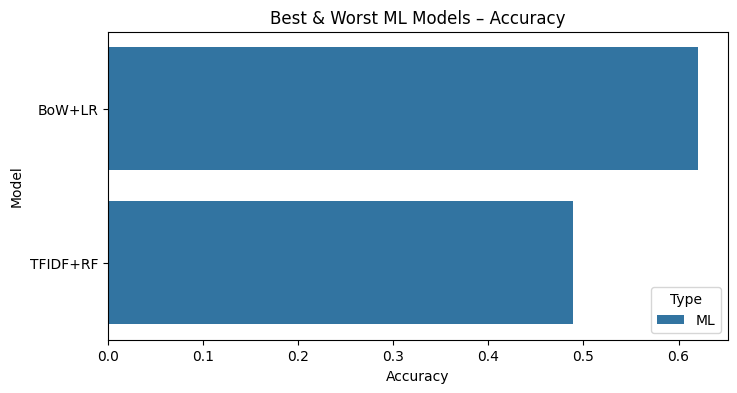

In [ ]:
#Accuracy (Best & Worst ML)
plt.figure(figsize=(8,4))
sns.barplot(x="Accuracy", y="Model", data=pd.concat([best_ml.to_frame().T, worst_ml.to_frame().T]), hue="Type", dodge=False)
plt.title("Best & Worst ML Models – Accuracy")
plt.show()



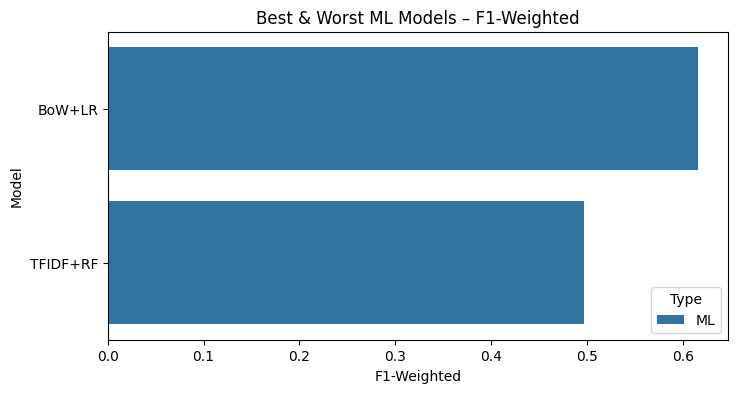

In [ ]:
#F1-Weighted (Best & Worst ML)
plt.figure(figsize=(8,4))
sns.barplot(x="F1-Weighted", y="Model", data=pd.concat([best_ml.to_frame().T, worst_ml.to_frame().T]), hue="Type", dodge=False)
plt.title("Best & Worst ML Models – F1-Weighted")
plt.show()


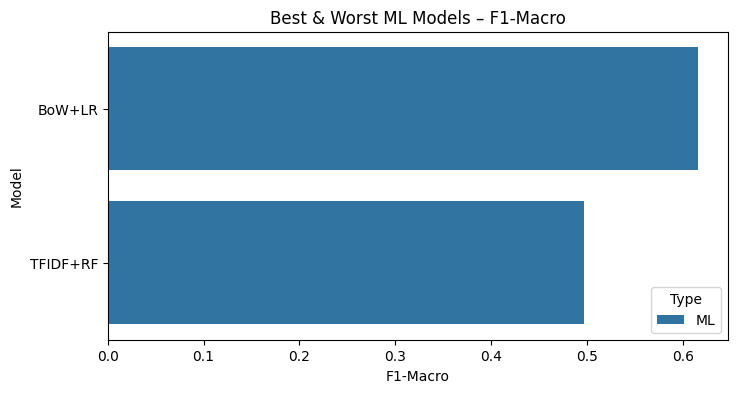

In [ ]:
#F1-Macro (Best & Worst ML)
plt.figure(figsize=(8,4))
sns.barplot(x="F1-Macro", y="Model", data=pd.concat([best_ml.to_frame().T, worst_ml.to_frame().T]), hue="Type", dodge=False)
plt.title("Best & Worst ML Models – F1-Macro")
plt.show()


Best and Worst NN models (Visual + Tabular)

In [ ]:
# Tabular – Best and Worst NN
df_nn = df_models[df_models['Type'] == "NN"]

# Best and Worst NN models by Accuracy
best_nn = df_nn.loc[df_nn['Accuracy'].idxmax()]
worst_nn = df_nn.loc[df_nn['Accuracy'].idxmin()]

print("=== Best NN Model  ===")
display(best_nn.to_frame().T)

print("=== Worst NN Model ===")
display(worst_nn.to_frame().T)


=== Best NN Model  ===


Model Type  Accuracy  F1-Macro F1-Weighted
10  GloVe+LSTM   NN  0.713845  0.708082    0.708082

=== Worst NN Model ===


Model Type  Accuracy  F1-Macro F1-Weighted
8  GloVe+SimpleRNN   NN  0.237271  0.152234    0.152235

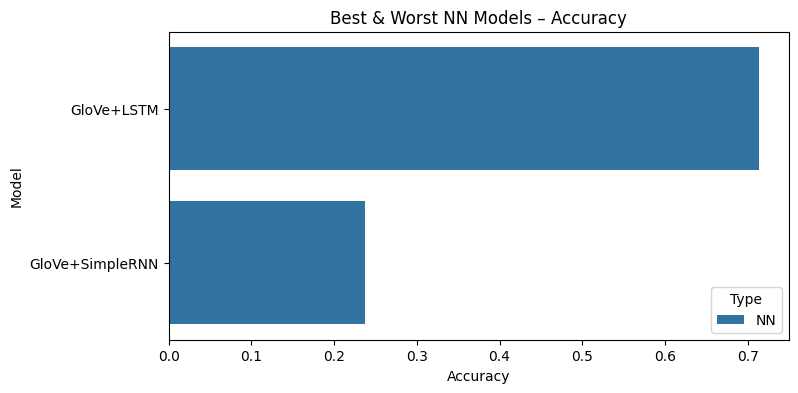

In [ ]:
#Accuracy (Best & Worst NN)
plt.figure(figsize=(8,4))
sns.barplot(x="Accuracy", y="Model", data=pd.concat([best_nn.to_frame().T, worst_nn.to_frame().T]), hue="Type", dodge=False)
plt.title("Best & Worst NN Models – Accuracy")
plt.show()


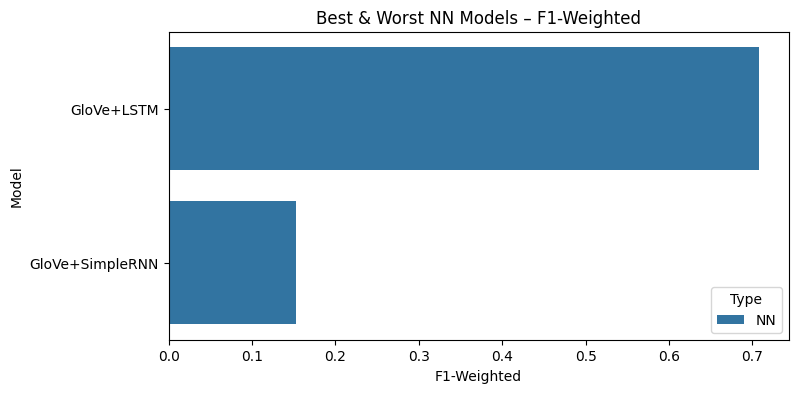

In [ ]:
#F1-Weighted (Best & Worst NN)
plt.figure(figsize=(8,4))
sns.barplot(x="F1-Weighted", y="Model", data=pd.concat([best_nn.to_frame().T, worst_nn.to_frame().T]), hue="Type", dodge=False)
plt.title("Best & Worst NN Models – F1-Weighted")
plt.show()



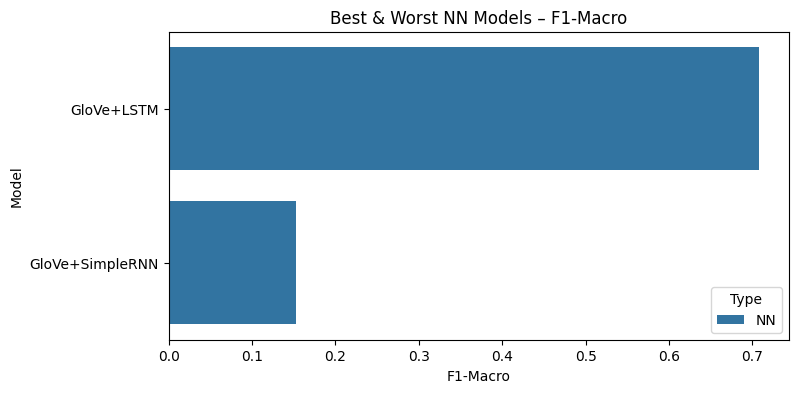

In [ ]:
#F1-Macro (Best & Worst NN)
plt.figure(figsize=(8,4))
sns.barplot(x="F1-Macro", y="Model", data=pd.concat([best_nn.to_frame().T, worst_nn.to_frame().T]), hue="Type", dodge=False)
plt.title("Best & Worst NN Models – F1-Macro")
plt.show()


BEST & WORST OVERALL MODELS

In [ ]:
#Tabular – Best and Worst Overall
best_overall = df_models.loc[df_models['Accuracy'].idxmax()]
worst_overall = df_models.loc[df_models['Accuracy'].idxmin()]

print("=== Best Overall Model (Tabular) ===")
display(best_overall.to_frame().T)

print("=== Worst Overall Model (Tabular) ===")
display(worst_overall.to_frame().T)



=== Best Overall Model (Tabular) ===


Model Type  Accuracy  F1-Macro F1-Weighted
10  GloVe+LSTM   NN  0.713845  0.708082    0.708082

=== Worst Overall Model (Tabular) ===


Model Type  Accuracy  F1-Macro F1-Weighted
8  GloVe+SimpleRNN   NN  0.237271  0.152234    0.152235

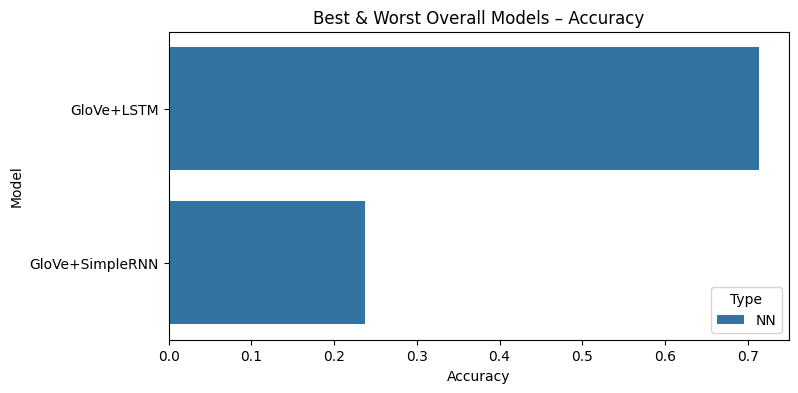

In [ ]:
#Accuracy (Best & Worst Overall)
plt.figure(figsize=(8,4))
sns.barplot(x="Accuracy", y="Model", data=pd.concat([best_overall.to_frame().T, worst_overall.to_frame().T]), hue="Type", dodge=False)
plt.title("Best & Worst Overall Models – Accuracy")
plt.show()


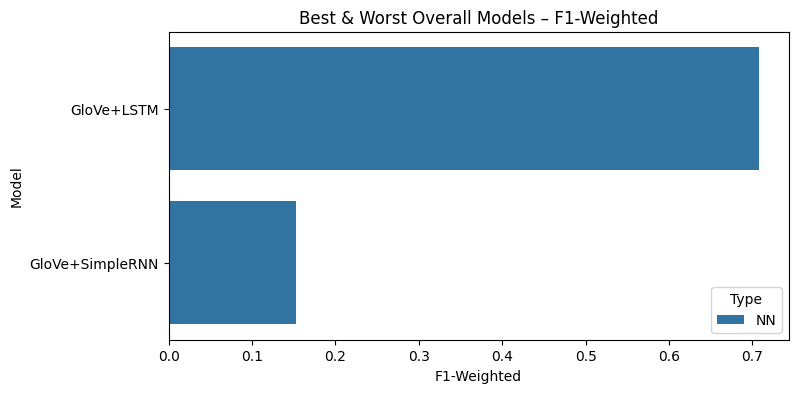

In [ ]:
#F1-Weighted (Best & Worst Overall)
plt.figure(figsize=(8,4))
sns.barplot(x="F1-Weighted", y="Model", data=pd.concat([best_overall.to_frame().T, worst_overall.to_frame().T]), hue="Type", dodge=False)
plt.title("Best & Worst Overall Models – F1-Weighted")
plt.show()


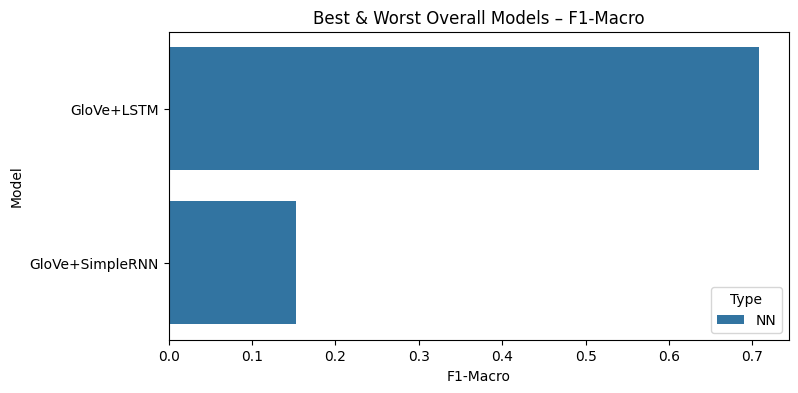

In [ ]:
#F1-Macro (Best & Worst Overall)
plt.figure(figsize=(8,4))
sns.barplot(x="F1-Macro", y="Model", data=pd.concat([best_overall.to_frame().T, worst_overall.to_frame().T]), hue="Type", dodge=False)
plt.title("Best & Worst Overall Models – F1-Macro")
plt.show()


comparison between the best-performing ML model and the best-performing NN model

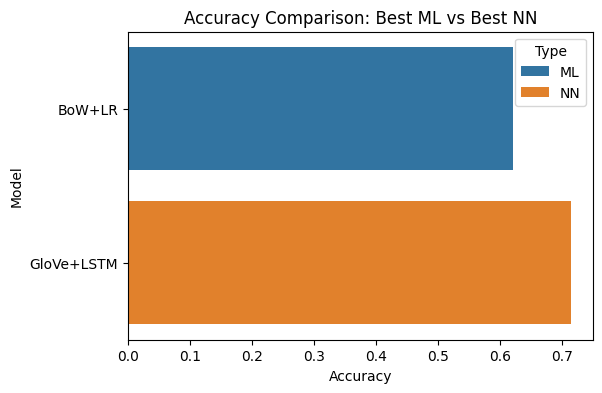

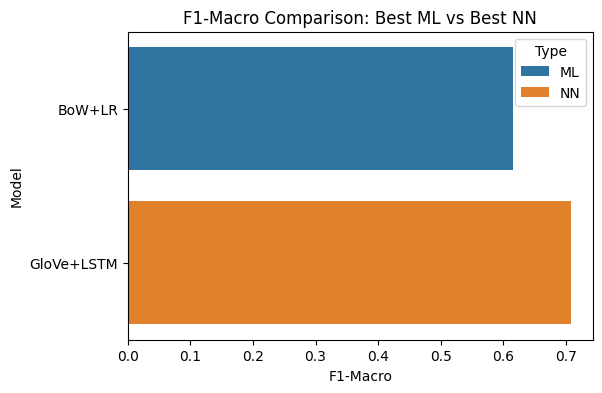

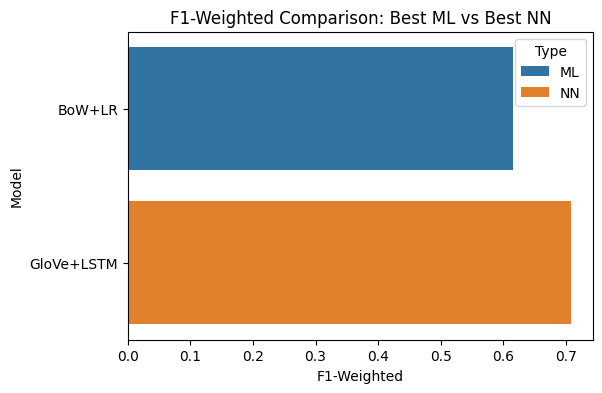

In [ ]:
# Combine both models
df_best_models = pd.concat([best_ml.to_frame().T, best_nn.to_frame().T])

# Accuracy
plt.figure(figsize=(6,4))
sns.barplot(x="Accuracy", y="Model", data=df_best_models, hue="Type", dodge=False)
plt.title("Accuracy Comparison: Best ML vs Best NN")
plt.show()

# F1-Macro
plt.figure(figsize=(6,4))
sns.barplot(x="F1-Macro", y="Model", data=df_best_models, hue="Type", dodge=False)
plt.title("F1-Macro Comparison: Best ML vs Best NN")
plt.show()

# F1-Weighted
plt.figure(figsize=(6,4))
sns.barplot(x="F1-Weighted", y="Model", data=df_best_models, hue="Type", dodge=False)
plt.title("F1-Weighted Comparison: Best ML vs Best NN")
plt.show()


In [ ]:
# Create a tabular comparison
comparison_df = pd.DataFrame({
    "Aspect": ["Model Name", "Type", "Accuracy", "F1-Macro", "F1-Weighted", "Training Time", "Interpretability", "Scalability"],
    "Best ML Model": [
        best_ml['Model'],
        best_ml['Type'],
        round(best_ml['Accuracy'], 4),
        round(best_ml['F1-Macro'], 4),
        round(best_ml['F1-Weighted'], 4),
        "Faster",
        "High",
        "Small/Medium datasets"
    ],
    "Best NN Model": [
        best_nn['Model'],
        best_nn['Type'],
        round(best_nn['Accuracy'], 4),
        round(best_nn['F1-Macro'], 4),
        round(best_nn['F1-Weighted'], 4),
        "Slower (GPU recommended)",
        "Low (Black box)",
        "Large datasets, embeddings"
    ]
})

print("=== Detailed Comparison: Best ML vs Best NN ===")
display(comparison_df)


=== Detailed Comparison: Best ML vs Best NN ===


Aspect          Best ML Model               Best NN Model
0        Model Name                 BoW+LR                  GloVe+LSTM
1              Type                     ML                          NN
2          Accuracy                 0.6207                      0.7138
3          F1-Macro                 0.6163                      0.7081
4       F1-Weighted                 0.6163                      0.7081
5     Training Time                 Faster    Slower (GPU recommended)
6  Interpretability                   High             Low (Black box)
7       Scalability  Small/Medium datasets  Large datasets, embeddings